# Dependencies

In [1]:
pacman::p_load(
    #igraph, graphlayouts, ggraph, ggforce, 
    dplyr, ggplot2, GUniFrac,
    dendextend, ComplexHeatmap, ANCOMBC, 
    TreeSummarizedExperiment, lsmeans
)

# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [4]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/run_gliph/"

# Main

In [5]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [6]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [7]:
meta_div$samplename <- paste0(meta_div$cancergroup, ":", meta_div$Patient, "_", meta_div$cycle, "-", meta_div$sampletype)
meta_div$samplename <- gsub(" ", "", meta_div$samplename)

In [9]:
gliph_out <- readr::read_csv(paste0(h4hpath, "/v5/gliph_output/int_vdj_v5_cluster.csv"), col_names = T) #  Mitchel as reference

Rows: 98847 Columns: 29
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (17): pattern, type, TcRb, V, J, Sample, HLA-A, HLA-B, HLA-C, HLA-DPA1, ...
dbl (11): index, Fisher_score, number_subject, number_unique_cdr3, final_sco...
lgl  (1): TcRa

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
# remove columns starting with HLA
gliph_out <- gliph_out[,!grepl("HLA", colnames(gliph_out))]

In [11]:
colnames(gliph_out)

[1] "index"              "pattern"            "Fisher_score"      
 [4] "number_subject"     "number_unique_cdr3" "final_score"       
 [7] "hla_score"          "vb_score"           "expansion_score"   
[10] "length_score"       "cluster_size_score" "type"              
[13] "TcRb"               "V"                  "J"                 
[16] "TcRa"               "Sample"             "Freq"

In [12]:
# no single
tmp <- gliph_out[ gliph_out$pattern != "single",]
# only those with 3 or more unique cdr3
tmp <- tmp[tmp$number_unique_cdr3 >= 3,]

tmp$subject <- gsub(":.*", "", tmp$Sample)

In [13]:
samples_tcr <- readr::read_rds( file = paste0(datapath, "GLIPH/int_samples_gliphannot_stat.rds"))
gliphdf <- readr::read_rds( file = paste0(datapath, "GLIPH/gliphannot_stat.rds"))

In [14]:
names(table(tmp$subject ))

[1] "CEF"                "CMV"                "EBV"               
 [4] "HCV"                "HPV"                "HomoSapiens"       
 [7] "Influenza"          "LFS"                "Leukemia"          
[10] "Lymphoma"           "M.tuberculosis"     "MCPyV"             
[13] "MDavis"             "Normal"             "S-pneumoniae"      
[16] "Solidtumors"        "T-cellmalignancies"

In [15]:
head(samples_tcr)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,S-pneumoniae,n_cdr3,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,2,0,0,0,0,0,15,3,3,Leukemia,X05,PBMC,5,CHP_319,1
Leukemia:CHP_323_X03-PBMC,2,0,1,0,0,16,0,0,0,1,0,45,21,12,Leukemia,X03,PBMC,3,CHP_323,1
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,33,0,0,0,0,1,103,49,25,Leukemia,X03,cfDNA,3,CHP_323,1
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,47,0,0,0,1,0,153,71,36,Leukemia,X05,PBMC,5,CHP_323,1
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,0,15,6,2,Leukemia,X05,cfDNA,5,CHP_323,1
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,5,0,0,0,0,0,25,8,4,Leukemia,X05,cfDNA,5,CHP_326,4


# Fisher test of finding a motif in pre vs post chemo

In [366]:
# bucket all postchemo together
samples_tcr$group <-NA
samples_tcr$group[ samples_tcr$cycle == "X01"] <- "pre"
samples_tcr$group[ samples_tcr$cycle != "X01"] <- "post"

In [367]:
samples_tcr$group <- factor(samples_tcr$group, levels = c("pre", "post"))

In [368]:
mymat <- as.data.frame(matrix(NA, nrow = 0, ncol = 6) )
colnames(mymat) <- c("Antigen", "Cancer", "p", "OR", "Lower", "Upper")

In [369]:
table(samples_tcr$cancergroup)


          Leukemia           Lymphoma        Solidtumors T-cellmalignancies 
               194                 64                129                 23 

In [370]:
for (c in c("Leukemia", "Lymphoma", "Solidtumors")) {
  print(c)
  pbmc <- samples_tcr[samples_tcr$sampletype == "PBMC", ]
  pbmc <- pbmc[pbmc$cancergroup == c, ]

pbmc <- pbmc[!is.na(pbmc$group),]

  for (v in c("CMV", "EBV", "HCV", "HPV", "Influenza", "MCPyV", "HomoSapiens")) {
    print(v)
    pbmc$Notfound <- pbmc$n_gliph - pbmc[[v]]

    contingency_table <- pbmc %>%
      group_by(group) %>%
      summarise(
        Motifs_Found = sum(eval(parse(text = v))),
        Motifs_Not_Found = sum(Notfound)
      )

    contingency_table <- as.data.frame(contingency_table)
    rownames(contingency_table) <- contingency_table$group
    contingency_table$group <- NULL
    contingency_table <- as.matrix(t(contingency_table))

    c1 <- fisher.test(contingency_table)

    mymat_c <- as.data.frame(matrix(NA, nrow = 1, ncol = 6))

    colnames(mymat_c) <- c( "Antigen", "Cancer", "p", "OR", "Lower", "Upper")
   
    mymat_c$Antigen[1] <- v
    mymat_c$Cancer[1] <- c
    mymat_c$p[1] <- c1$p.value
    mymat_c$OR[1] <- c1$estimate
    mymat_c$Lower[1] <- c1$conf.int[1]
    mymat_c$Upper[1] <- c1$conf.int[2]
    mymat <- rbind(mymat, mymat_c[1,])
  } # end of virus loop
  mymat <- rbind(mymat, mymat_c)
} # end of cancer loop


[1] "Leukemia"
[1] "CMV"
[1] "EBV"
[1] "HCV"
[1] "HPV"
[1] "Influenza"
[1] "MCPyV"
[1] "HomoSapiens"
[1] "Lymphoma"
[1] "CMV"
[1] "EBV"
[1] "HCV"
[1] "HPV"
[1] "Influenza"
[1] "MCPyV"
[1] "HomoSapiens"
[1] "Solidtumors"
[1] "CMV"
[1] "EBV"
[1] "HCV"
[1] "HPV"
[1] "Influenza"
[1] "MCPyV"
[1] "HomoSapiens"


In [372]:
head(samples_tcr)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,n_cdr3,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,2,0,0,0,0,...,15,3,3,Leukemia,X05,PBMC,5,CHP_319,1,post
Leukemia:CHP_323_X03-PBMC,2,0,1,0,0,16,0,0,0,1,...,45,21,12,Leukemia,X03,PBMC,3,CHP_323,1,post
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,33,0,0,0,0,...,103,49,25,Leukemia,X03,cfDNA,3,CHP_323,1,post
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,47,0,0,0,1,...,153,71,36,Leukemia,X05,PBMC,5,CHP_323,1,post
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,...,15,6,2,Leukemia,X05,cfDNA,5,CHP_323,1,post
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,5,0,0,0,0,...,25,8,4,Leukemia,X05,cfDNA,5,CHP_326,4,post


In [373]:
contingency_table


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.232
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8807361 1.5812877
sample estimates:
odds ratio 
  1.185801 


In [154]:
# pbmc <- samples_tcr[samples_tcr$sampletype == "cfDNA", ]
# pbmc <- pbmc[pbmc$cancergroup == "Leukemia", ]

#     pbmc$Notfound <- pbmc$n_gliph - pbmc$HomoSapiens

#     contingency_table <- pbmc %>%
#       group_by(group) %>%
#       summarise(
#         Motifs_Found = sum(HomoSapiens),
#         Motifs_Not_Found = sum(Notfound)
#       )

#     contingency_table <- as.data.frame(contingency_table)
#     rownames(contingency_table) <- contingency_table$group
#     contingency_table$group <- NULL
#     contingency_table <- as.matrix(t(contingency_table))

#     c1 <- fisher.test(contingency_table)

In [155]:
mymat$padj <- p.adjust(mymat$p, method = "fdr")

In [156]:
mymat[order(mymat$padj),]

,Antigen,Cancer,p,OR,Lower,Upper,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,MCPyV,Solidtumors,0.001126502,0.1538678,0.018037001,0.5928406,0.02703605
4,HPV,Leukemia,0.027866528,2.1386070,1.058232913,4.1002458,0.20951079
7,HomoSapiens,Leukemia,0.043648082,0.7547400,0.566014512,0.9919873,0.20951079
8,HomoSapiens,Leukemia,0.043648082,0.7547400,0.566014512,0.9919873,0.20951079
14,MCPyV,Lymphoma,0.027290524,5.9613420,0.971929032,62.8622068,0.20951079
3,HCV,Leukemia,0.173908607,1.3434082,0.865256541,2.0282845,0.43874970
5,Influenza,Leukemia,0.176649863,2.1590157,0.595183859,6.5917719,0.43874970
15,HomoSapiens,Lymphoma,0.218935997,0.6726058,0.347977014,1.2282312,0.43874970
16,HomoSapiens,Lymphoma,0.218935997,0.6726058,0.347977014,1.2282312,0.43874970


In [232]:
meta_div[meta_div$Patient == "CHP_408",]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,samplename
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
746,CHP_408_01,CHP_408,X01,5.1,338.80,5,OS,5.1,2140,338,...,0.267,8.287,8.391,0.424,CHP_408-01_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_408-01_PBMC-DNA.txt,PBMC,CHP,1.0133429,Solidtumors:CHP_408_X01-PBMC
747,CHP_408_02,CHP_408,X02,4.3,0.00,5,OS,4.3,2395,522,...,0.615,41.106,41.993,1.097,CHP_408-02_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_408-02_PBMC-DNA.txt,PBMC,CHP,1.6736843,Solidtumors:CHP_408_X02-PBMC
748,CHP_408_03,CHP_408,X03,5.4,69.16,5,OS,5.4,1395,42,...,1.080,483.728,486.071,1.633,CHP_408-03-PBMC-DNA,batch13_26Aug2020/mixcr/clones/CLONES_TRBCHP_408-03-PBMC-DNA.txt,PBMC,CHP,2.7585501,Solidtumors:CHP_408_X03-PBMC
253,CHP_408_01,CHP_408,X01,5.1,338.80,5,OS,5.1,2140,338,...,0.049,1.571,1.572,0.043,CHP_408-01_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_408-01_cfDNA.txt,cfDNA,CHP,0.2869054,Solidtumors:CHP_408_X01-cfDNA
254,CHP_408_02,CHP_408,X02,4.3,0.00,5,OS,4.3,2395,522,...,0.049,1.874,1.875,0.032,CHP_408-02_cfDNA,remaining_batch_1_cfDNA_8April2021/mixcr/clones/CLONES_TRBCHP_408-02_cfDNA.txt,cfDNA,CHP,0.4032921,Solidtumors:CHP_408_X02-cfDNA
255,CHP_408_03,CHP_408,X03,5.4,69.16,5,OS,5.4,1395,42,...,0.072,11.473,11.480,0.078,CHP_408-03_cfDNA,priority_pool2/mixcr/clones/CLONES_TRBCHP_408-03_cfDNA.txt,cfDNA,CHP,1.1228382,Solidtumors:CHP_408_X03-cfDNA


In [230]:
pbmc$tmp <- pbmc$MCPyV / pbmc$n_gliph

In [231]:
pbmc

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age,group,tmp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>
Solidtumors:CHP_350_X05-PBMC,0,0,0,0,1,16,0,0,0,1,...,22,10,Solidtumors,X05,PBMC,5,CHP_350,1,post,0.04545455
Solidtumors:CHP_381_X02-PBMC,4,7,5,0,17,267,3,1,0,8,...,361,185,Solidtumors,X02,PBMC,2,CHP_381,6,post,0.02216066
Solidtumors:CHP_408_X02-PBMC,0,0,0,0,1,10,0,0,0,1,...,17,11,Solidtumors,X02,PBMC,2,CHP_408,5,post,0.05882353


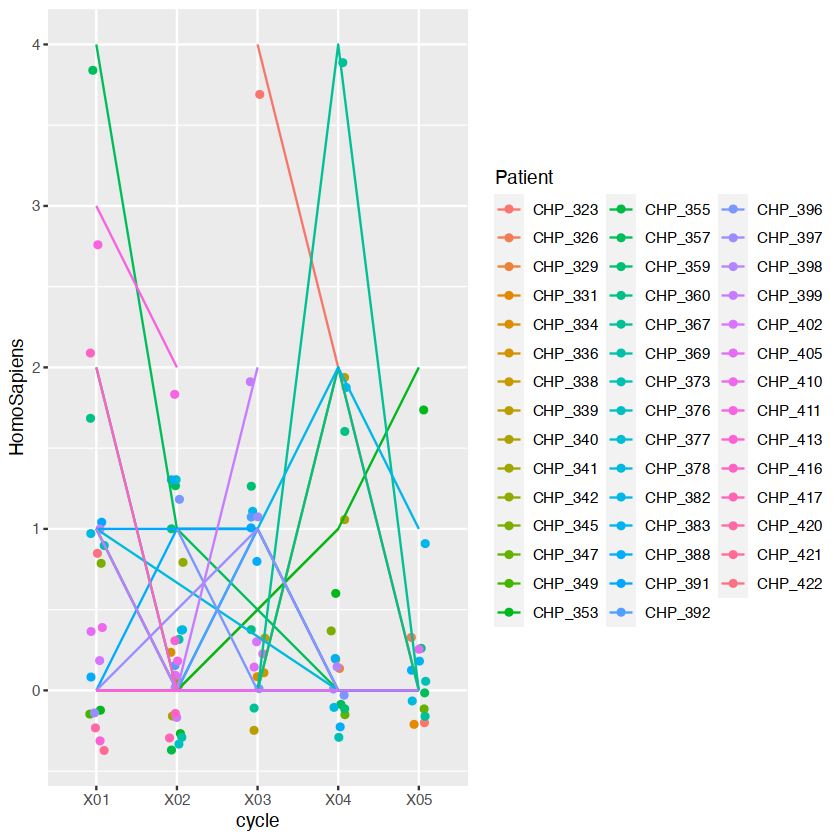

In [323]:
pbmc <- samples_tcr[samples_tcr$sampletype == "cfDNA", ]
pbmc <- pbmc[pbmc$cancergroup == "Leukemia", ]

ggplot(pbmc, aes(x = cycle, y = HomoSapiens, group = Patient, color = Patient)) + geom_jitter(width = 0.1) + geom_line()

In [345]:
pbmc[ pbmc$group == "pre", ]

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,n_cdr3,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>
Leukemia:CHP_345_X01-cfDNA,2,1,0,1,1,28,0,0,0,1,...,33,30,12,Leukemia,X01,cfDNA,1,CHP_345,1,pre
Leukemia:CHP_349_X01-cfDNA,0,0,1,0,0,3,0,0,0,0,...,2,4,2,Leukemia,X01,cfDNA,1,CHP_349,17,pre
Leukemia:CHP_353_X01-cfDNA,0,0,0,0,0,1,0,0,0,0,...,5,1,1,Leukemia,X01,cfDNA,1,CHP_353,6,pre
Leukemia:CHP_357_X01-cfDNA,0,0,1,0,4,9,0,0,0,0,...,22,14,6,Leukemia,X01,cfDNA,1,CHP_357,1,pre
Leukemia:CHP_360_X01-cfDNA,0,0,0,0,2,14,0,0,0,0,...,42,24,14,Leukemia,X01,cfDNA,1,CHP_360,6,pre
Leukemia:CHP_376_X01-cfDNA,0,0,0,0,1,1,0,0,0,0,...,5,2,2,Leukemia,X01,cfDNA,1,CHP_376,1,pre
Leukemia:CHP_378_X01-cfDNA,0,0,0,0,1,9,0,0,0,0,...,27,14,7,Leukemia,X01,cfDNA,1,CHP_378,1,pre
Leukemia:CHP_388_X01-cfDNA,0,0,0,0,0,4,1,0,0,0,...,14,6,5,Leukemia,X01,cfDNA,1,CHP_388,4,pre
Leukemia:CHP_391_X01-cfDNA,0,0,0,0,1,2,0,0,0,0,...,3,5,3,Leukemia,X01,cfDNA,1,CHP_391,10,pre


In [335]:
mygliphs <- unique(tmp$pattern[ tmp$Sample %in% rownames(pbmc)[ rownames(pbmc) == "Leukemia:CHP_411_X01-cfDNA"]] )

In [338]:
tmp[tmp$pattern %in% mygliphs & tmp$subject == "HomoSapiens",]

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
1412,S%RGSYE,5.0e-08,5,9,1.2e-07,1,0.530,0.48,0.001,0.00048,global-S%RGSYE,CASSLRGSYEQYV,NA,NA,NA,HomoSapiens:DNMT3A_p-P282S,1,HomoSapiens
12769,SQGLAG%GE,2.7e-03,3,3,3.7e-08,1,0.011,0.54,0.001,0.00620,global-SQGLAG%GE,CASSQGLAGAGELFF,TRBV19,TRBJ2-2,NA,HomoSapiens:MLANA_ELAGIGILTV,1,HomoSapiens
21458,S%GLAGAGE,1.8e-02,3,3,1.4e-07,1,0.033,0.67,0.001,0.00620,global-S%GLAGAGE,CASSQGLAGAGELFF,TRBV19,TRBJ2-2,NA,HomoSapiens:MLANA_ELAGIGILTV,1,HomoSapiens


In [348]:
tmp[tmp$pattern %in% "SQGLAG%GE",]

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
12769,SQGLAG%GE,0.0027,3,3,3.7e-08,1,0.011,0.54,0.001,0.0062,global-SQGLAG%GE,CASSQGLAGVGELFF,TRBV14_1,NA,NA,MDavis:C0102,1,MDavis
12769,SQGLAG%GE,0.0027,3,3,3.7e-08,1,0.011,0.54,0.001,0.0062,global-SQGLAG%GE,CASSQGLAGAGELFF,TRBV3-1,TRBJ2-2,NA,Leukemia:CHP_411_X01-cfDNA,134,Leukemia
12769,SQGLAG%GE,0.0027,3,3,3.7e-08,1,0.011,0.54,0.001,0.0062,global-SQGLAG%GE,CASSQGLAGAGELFF,TRBV19,TRBJ2-2,NA,HomoSapiens:MLANA_ELAGIGILTV,1,HomoSapiens
12769,SQGLAG%GE,0.0027,3,3,3.7e-08,1,0.011,0.54,0.001,0.0062,global-SQGLAG%GE,CASSQGLAGVGEQFF,TRBV14_1,NA,NA,MDavis:C0102,1,MDavis


In [328]:
mygliphs

[1] "SLG%E"      "GIWV"       "IWV"        "WVYE"       "IWVY"      
  [6] "SV%GNTE"    "TGIW"       "SLG%NTE"    "SY%GTE"     "SL%GE"     
 [11] "SQDR%T"     "S%MNTE"     "S%SNQP"     "S%NTE"      "SP%NTE"    
 [16] "R%GMNTE"    "S%TGGTE"    "S%SNTE"     "S%NTGE"     "SL%SGGE"   
 [21] "SLD%NTE"    "SLTSG%YNE"  "S%RGTE"     "SL%ENTE"    "SPS%TE"    
 [26] "SLGQ%NEK"   "%VLGDE"     "SPN%E"      "SL%TDT"     "SL%TGIWVYE"
 [31] "S%YNE"      "S%GSE"      "SLVSG%E"    "SL%QGAYE"   "SRQG%GTE"  
 [36] "SQD%NQP"    "SSG%TYE"    "SYR%E"      "SLG%ET"     "S%RGSYE"   
 [41] "SSGLAT%E"   "%ISGANV"    "SS%RGKET"   "SLEGL%TGE"  "SP%TE"     
 [46] "SY%GE"      "SL%SE"      "S%DSNSP"    "SFTG%TE"    "S%STDT"    
 [51] "SSP%AGNTE"  "SLRPP%I"    "S%AGNTE"    "RIWV"       "SLVGG%TDT" 
 [56] "SYP%TE"     "SF%GGTE"    "SEAGGP%E"   "SL%LNTE"    "SP%LQET"   
 [61] "S%PGTE"     "SLNP%TGE"   "SVGT%YE"    "SYPG%E"     "SP%YE"     
 [66] "R%GAGE"     "S%TSGDYNE"  "S%GVYG"     "R%SGANV"    "SVAG%TE"   
 [71] "SPQGA%G"    "S%GENTE"    "SVA%NTE"    "S%GQTYE"    "%LGENTE"   
 [76] "%LGSE"      "SP%GSYE"    "SLGS%"      "S%ELNQP"    "SSGQTY%"   
 [81] "S%GQATNEK"  "SH%TGE"     "SQE%TSYNE"  "SF%SYE"     "SVS%SE"    
 [86] "SPR%SYE"    "SLGGG%QP"   "SYS%SP"     "S%DLNTE"    "%SDEK"     
 [91] "SS%GGYG"    "SPGGTY%"    "G%QGGNQP"   "SL%GLDTE"   "SR%YNE"    
 [96] "SEG%YG"     "S%RGNEK"    "SIDR%YG"    "S%QGWGTE"   "SQD%RGNQP" 
[101] "S%GSGET"    "SL%RET"     "%VAGNTE"    "SQD%MNTE"   "S%AGGPNE"  
[106] "%PNTE"      "SRDR%TNEK"  "S%NEK"      "TGQ%NTE"    "HR%MNTE"   
[111] "RD%YE"      "S%ISYE"     "TQG%YG"     "%RET"       "%SGQTYE"   
[116] "SPG%TYG"    "SQDS%NTE"   "SP%VTDT"    "SYPGT%"     "S%RGE"     
[121] "SLD%NSP"    "SSDRG%ET"   "SPSN%E"     "SSGQ%YE"    "S%GTGSYG"  
[126] "%YYNE"      "R%AGGTDT"   "SPA%TDT"    "S%DSMNTE"   "SLG%GDQP"  
[131] "S%LYE"      "SLVGD%"     "SEAGG%NE"   "SL%DRGYE"   "SQGLAG%GE" 
[136] "SLRT%YE"    "R%RGLNTE"   "%SYNE"      "SS%RAYE"    "SL%LAGVGE" 
[141] "SLS%DT"     "SQ%GNQP"    "SE%RGTE"    "%DRGLNTE"   "SLGGD%"    
[146] "SLG%GET"    "SPL%E"      "%DSTDT"     "R%TGGYG"    "S%PGG"     
[151] "S%DRET"     "S%GQP"      "%QGAGE"     "SQGG%T"     "SL%GDG"    
[156] "SFTGG%E"    "S%GQGNEK"   "SL%EK"      "%PMNTE"     "SPRG%YE"   
[161] "S%GLAGAGE"  "%NTE"       "VG%E"       "SLVG%G"     "SS%NE"     
[166] "%RGDTE"     "%GGE"       "R%YE"       "G%YNE"      "SSY%E"     
[171] "S%"         "RQG%GE"     "G%TE"

# 1- Rate of virus associated CDR3s

In [182]:
head(gliphdf)

,gliph,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,S-pneumoniae,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLG%E,SLG%E,0,0,0,0,0,39,0,0,0,0,0,50
S%GGNTE,S%GGNTE,0,0,0,0,1,40,0,0,0,0,0,41
GIWV,GIWV,0,0,0,0,0,0,0,0,0,0,0,82
IWV,IWV,0,0,0,0,1,0,0,0,0,0,0,97
WVYE,WVYE,0,0,0,0,0,0,0,0,0,0,0,98
IWVY,IWVY,0,0,0,0,0,0,0,0,0,0,0,95


In [187]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(tmp %>% select(pattern, Sample)))

In [188]:
head(pat_type)

,CEF:NA_NA,CMV:NA_NA,CMV:UL40_VMAPRTLIL,CMV:pp65_EFFWDANDIY,CMV:pp65_IPSINVHHY,CMV:pp65_NLVPMVATV,CMV:pp65_RPHERNGFTV,CMV:pp65_TPRVTGGGAM,EBV:BMLF1_GLCTLVAML,EBV:BZLF1_EPLPQGQLTAY,...,T-cellmalignancies:CHP_375_X04-cfDNA,T-cellmalignancies:CHP_375_X05-PBMC,T-cellmalignancies:CHP_375_X05-cfDNA,T-cellmalignancies:CHP_387_X01-PBMC,T-cellmalignancies:CHP_387_X01-cfDNA,T-cellmalignancies:CHP_387_X02-cfDNA,T-cellmalignancies:CHP_387_X03-PBMC,T-cellmalignancies:CHP_387_X03-cfDNA,T-cellmalignancies:CHP_395_X01-cfDNA,T-cellmalignancies:CHP_395_X02-cfDNA
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%AANTGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
%AAQET,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ADQET,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGANV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGANYG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
# just CHP samples
pat_type <- pat_type[, colnames(pat_type)[grepl("CHP", colnames(pat_type))]]

In [190]:
head(pat_type)

,Leukemia:CHP_319_X05-PBMC,Leukemia:CHP_323_X03-PBMC,Leukemia:CHP_323_X03-cfDNA,Leukemia:CHP_323_X05-PBMC,Leukemia:CHP_323_X05-cfDNA,Leukemia:CHP_326_X05-cfDNA,Leukemia:CHP_328_X04-PBMC,Leukemia:CHP_328_X05-PBMC,Leukemia:CHP_329_X04-cfDNA,Leukemia:CHP_331_X04-PBMC,...,T-cellmalignancies:CHP_375_X04-cfDNA,T-cellmalignancies:CHP_375_X05-PBMC,T-cellmalignancies:CHP_375_X05-cfDNA,T-cellmalignancies:CHP_387_X01-PBMC,T-cellmalignancies:CHP_387_X01-cfDNA,T-cellmalignancies:CHP_387_X02-cfDNA,T-cellmalignancies:CHP_387_X03-PBMC,T-cellmalignancies:CHP_387_X03-cfDNA,T-cellmalignancies:CHP_395_X01-cfDNA,T-cellmalignancies:CHP_395_X02-cfDNA
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%AANTGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
%AAQET,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%ADQET,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGANV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGANYG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%AGDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
pat_type$gliph <- rownames(pat_type)

In [217]:
# long format and remove 0
pat_type_long <- tidyr::pivot_longer(pat_type, !gliph, names_to = "Sample", values_to = "value")
pat_type_long <- pat_type_long[ pat_type_long$value != 0,]

In [218]:
#orderr by sample
pat_type_long <- pat_type_long[order(pat_type_long$Sample),]

In [219]:
head(pat_type_long)

gliph,Sample,value
<chr>,<chr>,<int>
S%QGMNTE,Leukemia:CHP_319_X05-PBMC,1
SLGLAG%ET,Leukemia:CHP_319_X05-PBMC,1
STG%ANSP,Leukemia:CHP_319_X05-PBMC,1
%GGNQP,Leukemia:CHP_323_X03-PBMC,1
RR%QET,Leukemia:CHP_323_X03-PBMC,1
S%AYE,Leukemia:CHP_323_X03-PBMC,1


In [220]:
mydat <- data.frame(matrix( nrow = nrow(pat_type_long), ncol = length(names(table(tmp$subject )) ),
dimnames = list(NULL, names(table(tmp$subject )))))

In [221]:
# pat_type_long <- cbind(pat_type_long, mydat)

In [235]:
head(pat_type_long)

gliph,Sample,value
<chr>,<chr>,<lgl>
S%QGMNTE,Leukemia:CHP_319_X05-PBMC,NA
SLGLAG%ET,Leukemia:CHP_319_X05-PBMC,NA
STG%ANSP,Leukemia:CHP_319_X05-PBMC,NA
%GGNQP,Leukemia:CHP_323_X03-PBMC,NA
RR%QET,Leukemia:CHP_323_X03-PBMC,NA
S%AYE,Leukemia:CHP_323_X03-PBMC,NA


In [239]:
pat_type_long$value <- NA

In [240]:
for (i in unique(pat_type_long$Sample)) {
    mysample <- i

    mysample_gliphout <- tmp[tmp$Sample == mysample, ]
    mytab <- as.data.frame(table(mysample_gliphout$pattern), stringsAsFactors = FALSE)

pat_type_long[pat_type_long$Sample == mysample &
match(pat_type_long$gliph, mytab$Var1), "value"] <- mytab$Freq

    # mygliph_annot <- as.data.frame.matrix(table(mygliphout$pattern, mygliphout$subject))
    # mygliph_annot$Sample <- mysample

    # pat_type_long[pat_type_long$Sample == mysample &
    #     match(pat_type_long$gliph, rownames(mygliph_annot)), colnames(mygliph_annot)[colnames(mygliph_annot) != "Sample"]] <- mygliph_annot[, colnames(mygliph_annot) != "Sample"]
}


In [242]:
tail(pat_type_long)

gliph,Sample,value
<chr>,<chr>,<int>
S%GGAPDT,T-cellmalignancies:CHP_395_X02-cfDNA,1
S%GLRTDT,T-cellmalignancies:CHP_395_X02-cfDNA,1
SIDR%YG,T-cellmalignancies:CHP_395_X02-cfDNA,1
SL%PGNE,T-cellmalignancies:CHP_395_X02-cfDNA,1
SLQGP%YG,T-cellmalignancies:CHP_395_X02-cfDNA,2
SPGL%TDT,T-cellmalignancies:CHP_395_X02-cfDNA,1


In [243]:
mysample

[1] "T-cellmalignancies:CHP_395_X02-cfDNA"

In [225]:
mysample_gliphout <- tmp[tmp$Sample == mysample, ]

In [231]:
mytab

Var1,Freq
<chr>,<int>
S%QGMNTE,1
SLGLAG%ET,1
STG%ANSP,1


In [202]:
mysample <- i


mypatterns <- unique(tmp$pattern[tmp$Sample == mysample])

In [214]:
tmp[ tmp$pattern == "SLQGP%YG",]

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.16,0.001,0.0062,global-SLQGP%YG,CASSLQGPNYGYTF,TRBV28,TRBJ1-2,NA,Leukemia:CHP_365_X01-PBMC,455,Leukemia
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.16,0.001,0.0062,global-SLQGP%YG,CASSLQGPDYGYTF,TRBV5-4,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,39,T-cellmalignancies
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.16,0.001,0.0062,global-SLQGP%YG,CASSLQGPDYGYTF,TRBV5-4,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,3,T-cellmalignancies
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.16,0.001,0.0062,global-SLQGP%YG,CASSLQGPPYGYTF,TRBV12-4,TRBJ1-2,NA,Solidtumors:CHP_414_X02-PBMC,54,Solidtumors


In [207]:
mypattern

[1] "SLQGP%YG"

In [213]:
gliphdf[ "SLQGP%YG",]

,gliph,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,S-pneumoniae,n_unique_cdr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLQGP%YG,SLQGP%YG,0,0,0,0,0,0,0,0,0,0,0,3


In [211]:
mysample_gliphout <- tmp[tmp$Sample == mysample, ]

In [212]:
mysample_gliphout

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.160,0.001,0.0062,global-SLQGP%YG,CASSLQGPDYGYTF,TRBV5-4,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,39,T-cellmalignancies
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.160,0.001,0.0062,global-SLQGP%YG,CASSLQGPDYGYTF,TRBV5-4,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,3,T-cellmalignancies
8185,SIDR%YG,0.00052,3,3,9.4e-10,1,0.004,0.038,0.001,0.0062,global-SIDR%YG,CASSIDREYGYTF,TRBV19,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,1,T-cellmalignancies
9383,S%GGAPDT,0.00090,4,3,9.7e-10,1,0.001,0.160,0.001,0.0062,global-S%GGAPDT,CASSFGGAPDTQYF,TRBV5-1,TRBJ2-3,NA,T-cellmalignancies:CHP_395_X02-cfDNA,67,T-cellmalignancies
11454,R%AGGTDT,0.00180,2,4,1.7e-09,1,0.028,0.026,0.001,0.0023,global-R%AGGTDT,CASRWAGGTDTQYF,TRBV6-2,TRBJ2-3,NA,T-cellmalignancies:CHP_395_X02-cfDNA,2033,T-cellmalignancies
11677,S%GLRTDT,0.00210,2,3,4.4e-08,1,0.091,0.078,0.001,0.0062,global-S%GLRTDT,CAISPGLRTDTQYF,TRBV10-3,TRBJ2-3,NA,T-cellmalignancies:CHP_395_X02-cfDNA,705,T-cellmalignancies
13830,R%RGLNTE,0.00400,4,3,6.2e-12,1,0.001,0.001,0.001,0.0062,global-R%RGLNTE,CSARDRGLNTEAFF,TRBV20-1,TRBJ1-1,NA,T-cellmalignancies:CHP_395_X02-cfDNA,1939,T-cellmalignancies
15294,SL%PGNE,0.00550,3,3,2.1e-07,1,0.040,0.840,0.001,0.0062,global-SL%PGNE,CASSLRPGNEQFF,TRBV7-9,TRBJ2-1,NA,T-cellmalignancies:CHP_395_X02-cfDNA,17,T-cellmalignancies
15903,%DRGLNTE,0.00630,4,3,6.2e-12,1,0.001,0.001,0.001,0.0062,global-%DRGLNTE,CSARDRGLNTEAFF,TRBV20-1,TRBJ1-1,NA,T-cellmalignancies:CHP_395_X02-cfDNA,1939,T-cellmalignancies


In [198]:
for (i in unique(pat_type_long$Sample)) {
    mysample <- i
    mypatterns <- unique(tmp$pattern[tmp$Sample == mysample])
    mysample_gliphout <- tmp[tmp$Sample == mysample, ]

    mygliph_annot <- as.data.frame.matrix(table(mygliphout$pattern, mygliphout$subject))
    mygliph_annot$Sample <- mysample

    pat_type_long[pat_type_long$Sample == mysample &
        match(pat_type_long$gliph, rownames(mygliph_annot)), colnames(mygliph_annot)[colnames(mygliph_annot) != "Sample"]] <- mygliph_annot[, colnames(mygliph_annot) != "Sample"]
}


In [200]:
i

[1] "T-cellmalignancies:CHP_395_X02-cfDNA"

In [201]:
(mygliphout)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.160,0.001,0.0062,global-SLQGP%YG,CASSLQGPNYGYTF,TRBV28,TRBJ1-2,NA,Leukemia:CHP_365_X01-PBMC,455,Leukemia
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.160,0.001,0.0062,global-SLQGP%YG,CASSLQGPDYGYTF,TRBV5-4,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,39,T-cellmalignancies
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.160,0.001,0.0062,global-SLQGP%YG,CASSLQGPDYGYTF,TRBV5-4,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,3,T-cellmalignancies
7277,SLQGP%YG,0.00031,3,3,3.9e-09,1,0.004,0.160,0.001,0.0062,global-SLQGP%YG,CASSLQGPPYGYTF,TRBV12-4,TRBJ1-2,NA,Solidtumors:CHP_414_X02-PBMC,54,Solidtumors
8185,SIDR%YG,0.00052,3,3,9.4e-10,1,0.004,0.038,0.001,0.0062,global-SIDR%YG,CASSIDRNYGYTF,TRBV19,TRBJ1-2,NA,Solidtumors:CHP_401_X03-PBMC,7,Solidtumors
8185,SIDR%YG,0.00052,3,3,9.4e-10,1,0.004,0.038,0.001,0.0062,global-SIDR%YG,CASSIDREYGYTF,TRBV19,TRBJ1-2,NA,Leukemia:CHP_411_X01-cfDNA,1356,Leukemia
8185,SIDR%YG,0.00052,3,3,9.4e-10,1,0.004,0.038,0.001,0.0062,global-SIDR%YG,CASSIDREYGYTF,TRBV19,TRBJ1-2,NA,T-cellmalignancies:CHP_395_X02-cfDNA,1,T-cellmalignancies
8185,SIDR%YG,0.00052,3,3,9.4e-10,1,0.004,0.038,0.001,0.0062,global-SIDR%YG,CASSIDRHYGYTF,TRBV2,TRBJ1-2,NA,Leukemia:CHP_345_X04-PBMC,14,Leukemia
9383,S%GGAPDT,0.00090,4,3,9.7e-10,1,0.001,0.160,0.001,0.0062,global-S%GGAPDT,CASSVGGAPDTQYF,TRBV9,TRBJ2-3,NA,T-cellmalignancies:CHP_375_X02-PBMC,10,T-cellmalignancies


In [165]:
pat_type_long[ is.na(pat_type_long)] <- 0

In [177]:
head(pat_type_long)

,gliph,Sample,value,CEF,CMV,EBV,HCV,HPV,HomoSapiens,Influenza,...,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S.pneumoniae,Solidtumors,T.cellmalignancies,T-cellmalignancies,S-pneumoniae
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,S%QGMNTE,Leukemia:CHP_319_X05-PBMC,1,0,0,0,0,0,0,0,...,0,0,0,7,0,0,0,0,0,0
2,SLGLAG%ET,Leukemia:CHP_319_X05-PBMC,1,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,0,0,0
3,STG%ANSP,Leukemia:CHP_319_X05-PBMC,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
4,%GGNQP,Leukemia:CHP_323_X03-PBMC,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,RR%QET,Leukemia:CHP_323_X03-PBMC,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,S%AYE,Leukemia:CHP_323_X03-PBMC,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [168]:
head(samples_tcr)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,S-pneumoniae,n_cdr3,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,2,0,0,0,0,0,15,3,3,Leukemia,X05,PBMC,5,CHP_319,1
Leukemia:CHP_323_X03-PBMC,2,0,1,0,0,16,0,0,0,1,0,45,21,12,Leukemia,X03,PBMC,3,CHP_323,1
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,33,0,0,0,0,1,103,49,25,Leukemia,X03,cfDNA,3,CHP_323,1
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,47,0,0,0,1,0,153,71,36,Leukemia,X05,PBMC,5,CHP_323,1
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,0,15,6,2,Leukemia,X05,cfDNA,5,CHP_323,1
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,5,0,0,0,0,0,25,8,4,Leukemia,X05,cfDNA,5,CHP_326,4


In [180]:
samples_tcr_cdr3 <- pat_type_long %>% group_by(Sample) %>% summarise(across(4:21, ~sum(.x, na.rm = TRUE)))

In [181]:
head(samples_tcr_cdr3)

Sample,CMV,EBV,HCV,HPV,HomoSapiens,Influenza,LFS,Leukemia,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S.pneumoniae,Solidtumors,T.cellmalignancies,T-cellmalignancies,S-pneumoniae
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,0,1,8,0,0,0,17,0,0,2,0,0,0
Leukemia:CHP_323_X03-PBMC,2,0,2,0,0,0,5,73,0,0,1,41,0,0,23,0,2,0
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,0,6,207,12,0,0,177,2,0,73,0,3,1
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,0,10,323,26,0,1,241,0,0,123,0,14,0
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,0,2,19,1,0,0,15,0,0,4,0,1,0
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,0,2,53,6,0,0,15,2,0,10,0,2,0


# 2 Rate of annotated GLIPH groups

In [233]:
gliph_emerson <- readr::read_csv(paste0(h4hpath, "/Emerson/emerson_vdj_mdv_cluster.csv"), col_names = T) #  Mitchel as reference

gliph_emerson <- gliph_emerson[,!grepl("HLA", colnames(gliph_emerson))]

Rows: 74539 Columns: 29
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (17): pattern, type, TcRb, V, J, Sample, HLA-A, HLA-B, HLA-C, HLA-DPA1, ...
dbl (11): index, Fisher_score, number_subject, number_unique_cdr3, final_sco...
lgl  (1): TcRa

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [234]:
emerson <- gliph_emerson[ gliph_emerson$pattern != "single",]
emerson <- emerson[emerson$number_unique_cdr3 >= 3,]

In [240]:
emerson$subject <- gsub(":.*", "", emerson$Sample)
emerson$samplename <- gsub(".*:", "", emerson$Sample)

In [241]:
table(emerson$subject, useNA = "ifany")


           CEF            CMV            EBV        Emerson            HCV 
             2            112            120          15928             63 
           HPV    HomoSapiens      Influenza M.tuberculosis          MCPyV 
            57            318             40              1            110 
        MDavis   S-pneumoniae 
         36230             58 

In [242]:
allAdaptive <- readr::read_rds(file = paste0(datapath, "Adaptivedatasets/allAdaptive_good.rds"))
emerson_meta <- allAdaptive[ allAdaptive$study == "Emerson",]

CMVneg <- emerson_meta$sample_name[which(emerson_meta$disease == "Cytomegalovirus -")]
CMVpos <- emerson_meta$sample_name[which(emerson_meta$disease == "Cytomegalovirus +")]

In [243]:
head(emerson)

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,TcRb,V,J,TcRa,Sample,Freq,subject,samplename
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>
1,SLG%E,0,2,47,1.5e-11,1,0.001,0.98,0.001,1.5e-05,global-SLG%E,CASSLGREAFF,TRBV03,TRBJ01-01,NA,Emerson:P00332,85,Emerson,P00332
1,SLG%E,0,2,47,1.5e-11,1,0.001,0.98,0.001,1.5e-05,global-SLG%E,CASSLGREAFF,TRBV6_7,NA,NA,MDavis:DRB10401,1,MDavis,DRB10401
1,SLG%E,0,2,47,1.5e-11,1,0.001,0.98,0.001,1.5e-05,global-SLG%E,YASSLGLEQFF,TRBV6_7,NA,NA,MDavis:DQA10101_DRB10401,1,MDavis,DQA10101_DRB10401
1,SLG%E,0,2,47,1.5e-11,1,0.001,0.98,0.001,1.5e-05,global-SLG%E,CASSLGPEQFF,TRBV6_7,NA,NA,MDavis:DRB10401,1,MDavis,DRB10401
1,SLG%E,0,2,47,1.5e-11,1,0.001,0.98,0.001,1.5e-05,global-SLG%E,CASSLGGELFF,TRBV25-01,TRBJ01-04,NA,Emerson:P00564,277,Emerson,P00564
1,SLG%E,0,2,47,1.5e-11,1,0.001,0.98,0.001,1.5e-05,global-SLG%E,CASSLGGELFF,TRBV6_7,NA,NA,MDavis:DRB10401,1,MDavis,DRB10401


In [244]:
importantgliphs <- emerson$pattern[ emerson$samplename %in% CMVneg]
emerson_gliphs <- emerson[ emerson$pattern %in% importantgliphs,]

In [245]:
mytab <- as.data.frame.matrix(table(emerson_gliphs$pattern, emerson_gliphs$subject))

In [246]:
head(mytab)

,CEF,CMV,EBV,Emerson,HCV,HPV,HomoSapiens,Influenza,M.tuberculosis,MCPyV,MDavis,S-pneumoniae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
%A,0,0,0,3,0,0,1,0,0,0,0,0
%AGANV,0,0,0,1,0,0,0,0,0,0,2,0
%AGGNE,0,0,0,2,0,0,0,0,0,0,1,0
%AGNTGE,0,0,0,3,0,0,0,0,0,0,5,0
%AGTE,0,0,0,1,0,0,0,0,0,0,2,0
%AGTYE,0,0,0,2,0,0,0,0,0,0,2,0


In [247]:
# count each group once per gliph
mytab_1 <- mytab
mytab_1[mytab_1 > 1] <- 1

In [248]:
n_anno <- colSums(mytab_1 > 0)

In [249]:
head(n_anno)

CEF     CMV     EBV Emerson     HCV     HPV 
      2      65      43    5017      48      17

In [250]:
gliphinput <- read.table(paste0(h4hpath, "/Emerson/gliphinput_emerson_vdj_mdv.txt"), sep = "\t" ,header = F) #  Mitchel as reference

In [251]:
colnames(gliphinput) <- c("CDR3b","TRBV","TRBJ","CDR3a","subject:condition","count")

In [252]:
gliphinput$subject <- gsub(".*:", "", gliphinput$`subject:condition`)

In [253]:
head(gliphinput)

,CDR3b,TRBV,TRBJ,CDR3a,subject:condition,count,subject
,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>
1,CASSLGGGPFNEQFF,TRBV04-01,TRBJ02-01,NA,Emerson:P00404,7807,P00404
2,CASSQDPLRPWDEKLFF,TRBV04-01,TRBJ01-04,NA,Emerson:P00404,6319,P00404
3,CASSYWTPRSGANVLTF,TRBV06,TRBJ02-06,NA,Emerson:P00404,6164,P00404
4,CASSDDSSGANVLTF,TRBV06-04,TRBJ02-06,NA,Emerson:P00404,3969,P00404
5,CASTWTGSSYNEQFF,TRBV05-01,TRBJ02-01,NA,Emerson:P00404,3930,P00404
6,CASSPDGPLEQYF,TRBV05-04,TRBJ02-07,NA,Emerson:P00404,3473,P00404


In [255]:
gliphinput$disease <- emerson_meta$disease[match(gliphinput$subject, emerson_meta$sample_name)]

In [256]:
head(gliphinput)

,CDR3b,TRBV,TRBJ,CDR3a,subject:condition,count,subject,disease
,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,<chr>
1,CASSLGGGPFNEQFF,TRBV04-01,TRBJ02-01,NA,Emerson:P00404,7807,P00404,Cytomegalovirus -
2,CASSQDPLRPWDEKLFF,TRBV04-01,TRBJ01-04,NA,Emerson:P00404,6319,P00404,Cytomegalovirus -
3,CASSYWTPRSGANVLTF,TRBV06,TRBJ02-06,NA,Emerson:P00404,6164,P00404,Cytomegalovirus -
4,CASSDDSSGANVLTF,TRBV06-04,TRBJ02-06,NA,Emerson:P00404,3969,P00404,Cytomegalovirus -
5,CASTWTGSSYNEQFF,TRBV05-01,TRBJ02-01,NA,Emerson:P00404,3930,P00404,Cytomegalovirus -
6,CASSPDGPLEQYF,TRBV05-04,TRBJ02-07,NA,Emerson:P00404,3473,P00404,Cytomegalovirus -


In [258]:
table(gliphinput$disease)


Cytomegalovirus + Cytomegalovirus - 
             9000             21000 

In [259]:
base_rate_CMVneg <- n_anno / length(unique(gliphinput$CDR3b[ grepl("Cytomegalovirus -", gliphinput$disease)]))
base_rate_CMVpos <- n_anno / length(unique(gliphinput$CDR3b[ grepl("Cytomegalovirus +", gliphinput$disease)]))

# base_rate <- n_anno / length(unique(gliphinput$CDR3b[ grepl("Emerson", gliphinput$`subject:condition`)]))

In [261]:
base_rate <- base_rate_CMVneg

In [262]:
base_rate_CMVneg

base_rate_CMVpos

CEF            CMV            EBV        Emerson            HCV 
  9.948269e-05   3.233187e-03   2.138878e-03   2.495523e-01   2.387585e-03 
           HPV    HomoSapiens      Influenza M.tuberculosis          MCPyV 
  8.456029e-04   9.102666e-03   6.466375e-04   4.974135e-05   1.890171e-03 
        MDavis   S-pneumoniae 
  2.049841e-01   1.790688e-03

CEF            CMV            EBV        Emerson            HCV 
  6.979098e-05   2.268207e-03   1.500506e-03   1.750707e-01   1.674983e-03 
           HPV    HomoSapiens      Influenza M.tuberculosis          MCPyV 
  5.932233e-04   6.385874e-03   4.536413e-04   3.489549e-05   1.326029e-03 
        MDavis   S-pneumoniae 
  1.438043e-01   1.256238e-03

### 2.1- sample probablities of finding a viral group

In [350]:
samples_tcr_probs <- samples_tcr

In [351]:
head(samples_tcr_probs)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,n_cdr3,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,2,0,0,0,0,...,15,3,3,Leukemia,X05,PBMC,5,CHP_319,1,post
Leukemia:CHP_323_X03-PBMC,2,0,1,0,0,16,0,0,0,1,...,45,21,12,Leukemia,X03,PBMC,3,CHP_323,1,post
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,33,0,0,0,0,...,103,49,25,Leukemia,X03,cfDNA,3,CHP_323,1,post
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,47,0,0,0,1,...,153,71,36,Leukemia,X05,PBMC,5,CHP_323,1,post
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,...,15,6,2,Leukemia,X05,cfDNA,5,CHP_323,1,post
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,5,0,0,0,0,...,25,8,4,Leukemia,X05,cfDNA,5,CHP_326,4,post


In [352]:
samples_tcr_probs$Viral <- rowSums(samples_tcr_probs[, c("CMV", "EBV", "HCV", "Influenza", "HPV", "MCPyV")], na.rm = TRUE)

In [353]:
head(samples_tcr_probs)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,n_gliph,n_cdr3ingliph,cancergroup,cycle,sampletype,cyclenum,Patient,Age,group,Viral
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,2,0,0,0,0,...,3,3,Leukemia,X05,PBMC,5,CHP_319,1,post,0
Leukemia:CHP_323_X03-PBMC,2,0,1,0,0,16,0,0,0,1,...,21,12,Leukemia,X03,PBMC,3,CHP_323,1,post,4
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,33,0,0,0,0,...,49,25,Leukemia,X03,cfDNA,3,CHP_323,1,post,2
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,47,0,0,0,1,...,71,36,Leukemia,X05,PBMC,5,CHP_323,1,post,2
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,...,6,2,Leukemia,X05,cfDNA,5,CHP_323,1,post,0
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,5,0,0,0,0,...,8,4,Leukemia,X05,cfDNA,5,CHP_326,4,post,3


In [354]:
base_rate

CEF            CMV            EBV        Emerson            HCV 
  9.948269e-05   3.233187e-03   2.138878e-03   2.495523e-01   2.387585e-03 
           HPV    HomoSapiens      Influenza M.tuberculosis          MCPyV 
  8.456029e-04   9.102666e-03   6.466375e-04   4.974135e-05   1.890171e-03 
        MDavis   S-pneumoniae 
  2.049841e-01   1.790688e-03

In [355]:
samples_tcr_probs$Myp <- NA
for (i in 1:nrow(samples_tcr_probs)) {
    samples_tcr_probs$Myp[i] <- binom.test(x = samples_tcr_probs$MCPyV[i], n = samples_tcr_probs$n_gliph[i], 
    p = base_rate["MCPyV"], alternative = "greater")$p.value
}

samples_tcr_probs$HSapiens <- NA
for (i in 1:nrow(samples_tcr_probs)) {
    samples_tcr_probs$HSapiens[i] <- binom.test(x = samples_tcr_probs$HomoSapiens[i], n = samples_tcr_probs$n_gliph[i], 
    p = base_rate[ "HomoSapiens"], alternative = "greater")$p.value
}

In [356]:
samples_tcr_probs$Relapse <- meta_div$Relapse[match(rownames(samples_tcr_probs), meta_div$samplename)]

In [357]:
samples_tcr_probs$MCPyV_ratio <- samples_tcr_probs$MCPyV / samples_tcr_probs$n_gliph
samples_tcr_probs$HomoSapiens_ratio <- samples_tcr_probs$HomoSapiens / samples_tcr_probs$n_gliph

In [363]:
pbmc <- samples_tcr_probs[ samples_tcr_probs$sampletype == "cfDNA",]

In [365]:
-log10(0.01)

[1] 2

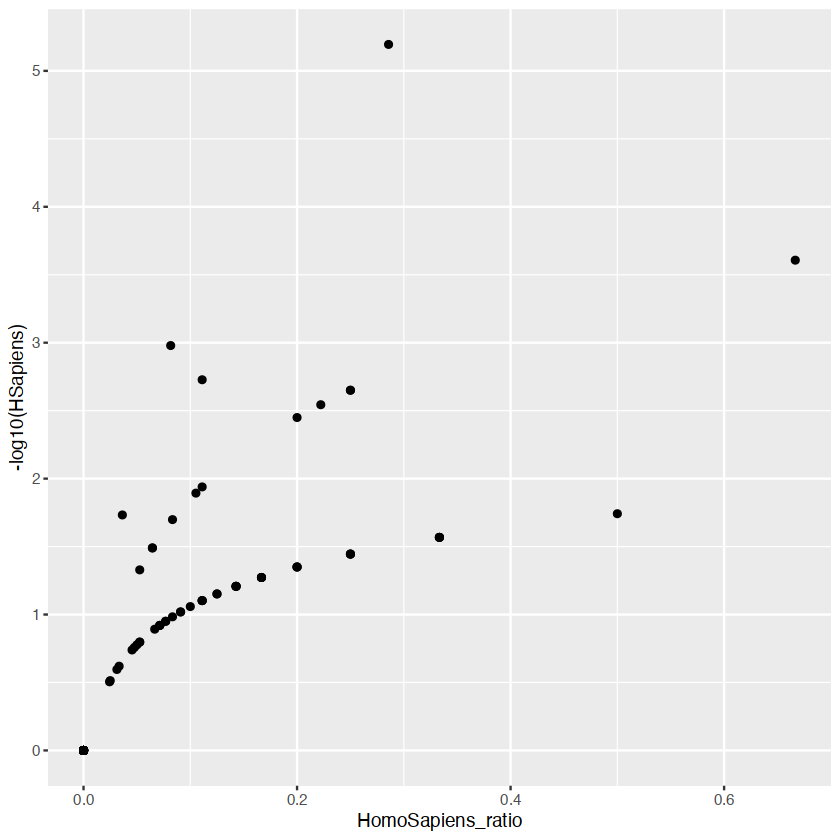

In [364]:
ggplot(data = pbmc, aes( x = HomoSapiens_ratio, y = -log10(HSapiens))) + geom_point()

In [310]:
tempo <- pbmc[ pbmc$cycle != "X01" & pbmc$cancergroup == "Solidtumors", ] %>% group_by(Patient) %>% reframe( sump = mean(psuccess), rel = Relapse, p = mean(Myp) )

In [311]:
tempo_dedup <- tempo[ !duplicated(tempo$Patient), ]

In [313]:
tempo

Patient,sump,rel,p
<chr>,<dbl>,<int>,<dbl>
CHP_330,0.000000000,0,1.000000e+00
CHP_335,0.000000000,0,1.000000e+00
CHP_343,0.000000000,0,1.000000e+00
CHP_343,0.000000000,0,1.000000e+00
CHP_343,0.000000000,0,1.000000e+00
CHP_343,0.000000000,0,1.000000e+00
CHP_348,0.000000000,0,1.000000e+00
CHP_350,0.017960317,0,3.201736e-01
CHP_350,0.017960317,0,3.201736e-01


In [304]:
f <- as.formula(paste0("rel~", "sump"))

lrmodel <- glm(f, data = tempo[ !duplicated(tempo$Patient), ], family = "binomial")

summary(lrmodel)



Call:
glm(formula = f, family = "binomial", data = tempo[!duplicated(tempo$Patient), 
    ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.91344  -0.91344  -0.34976  -0.04433   1.95225  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.6584     0.5835  -1.128    0.259
sump        -263.9580   214.3443  -1.231    0.218

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 24.564  on 23  degrees of freedom
Residual deviance: 20.748  on 22  degrees of freedom
AIC: 24.748

Number of Fisher Scoring iterations: 7


## 2.2 - Binomial probablities of finding at least one motif in a sample

In [35]:
samples_tcr_probs$CMVp <- 1 - (1 - base_rate["CMV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$EBVp <- 1 - (1 - base_rate["EBV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$Flup <- 1 - (1 - base_rate["Influenza"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$HCVp <- 1 - (1 - base_rate["HCV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$HPVp <- 1 - (1 - base_rate["HPV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$CEFp <- 1 - (1 - base_rate["CEF"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$HSp <- 1 - (1 - base_rate["HomoSapiens"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$MCPyVp <- 1 - (1 - base_rate["MCPyV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$MDavisp <- 1 - (1 - base_rate["MDavis"]) ^ samples_tcr_probs$n_cdr3

In [36]:
head(samples_tcr_probs)

,CMV,EBV,HCV,Influenza,HomoSapiens,MDavis,HPV,CEF,TB,MCPyV,...,Age,CMVp,EBVp,Flup,HCVp,HPVp,CEFp,HSp,MCPyVp,MDavisp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Leukemia:CHP_319_X05-PBMC,0,0,0,0,0,2,0,0,0,0,...,1,0.05308218,0.04241280,0.00972755,0.03568757,0.01318022,0.001395089,0.1406084,0.02891827,0.9799569
Leukemia:CHP_323_X03-PBMC,2,0,1,0,0,16,0,0,0,1,...,1,0.15094296,0.12191815,0.02889969,0.10328734,0.03902179,0.004179431,0.3652930,0.08427020,0.9999919
Leukemia:CHP_323_X03-cfDNA,2,0,0,0,4,33,0,0,0,0,...,1,0.31238652,0.25739497,0.06491967,0.22083639,0.08707897,0.009540498,0.6467256,0.18249634,1.0000000
Leukemia:CHP_323_X05-PBMC,1,0,0,0,2,47,0,0,0,1,...,1,0.42669551,0.35728417,0.09489720,0.30972647,0.12657416,0.014138937,0.7868187,0.25867443,1.0000000
Leukemia:CHP_323_X05-cfDNA,0,0,0,0,0,4,0,0,0,0,...,1,0.05308218,0.04241280,0.00972755,0.03568757,0.01318022,0.001395089,0.1406084,0.02891827,0.9799569
Leukemia:CHP_326_X05-cfDNA,0,0,3,0,0,5,0,0,0,0,...,4,0.08689551,0.06968386,0.01615996,0.05876888,0.02187038,0.002324067,0.2231834,0.04773102,0.9985211


In [75]:
pbmc <- samples_tcr_probs[ samples_tcr_probs$sampletype == "PBMC",]

In [77]:
pairwise.t.test(pbmc[ pbmc$cycle == "X01", "Influenza"], pbmc$cancergroup[ pbmc$cycle == "X01"], "none")


	Pairwise comparisons using t tests with pooled SD 

data:  pbmc[pbmc$cycle == "X01", "Influenza"] and pbmc$cancergroup[pbmc$cycle == "X01"] 

                   Leukemia Lymphoma Solidtumors
Lymphoma           0.91     -        -          
Solidtumors        0.65     0.68     -          
T-cellmalignancies 0.54     0.63     0.42       

P value adjustment method: none 

In [41]:
colnames(pbmc)

[1] "CMV"           "EBV"           "HCV"           "Influenza"    
 [5] "HomoSapiens"   "MDavis"        "HPV"           "CEF"          
 [9] "TB"            "MCPyV"         "S-pneumoniae"  "n_cdr3"       
[13] "n_gliph"       "n_cdr3ingliph" "cancergroup"   "cycle"        
[17] "sampletype"    "cyclenum"      "Patient"       "Age"          
[21] "CMVp"          "EBVp"          "Flup"          "HCVp"         
[25] "HPVp"          "CEFp"          "HSp"           "MCPyVp"       
[29] "MDavisp"

In [49]:
myfit <- lmerTest::lmer( EBVp ~ cyclenum + Age + (1 | Patient), data= pbmc[pbmc$cancergroup == "Solidtumors",])


In [50]:
anova(myfit)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
cyclenum,0.002061795,0.002061795,1,51.31856,0.02966074,0.8639397
Age,0.058660762,0.058660762,1,19.03543,0.84388684,0.3697818


# Backup

In [ ]:
# find probability of finding one gliph group of length G in a CDR3 of length L out of a sample of X CDR3 sequences

In [ ]:
# tmp$gliph_length <- nchar(tmp$pattern)

In [ ]:
int_vdj <- readr::read_rds( file = paste0(datapath, "capTCRseq/int_vdjdb_v2.rds"))

In [ ]:
head(int_vdj)

In [ ]:
int_vdj[ int_vdj$CDR3b == "CSAKHGSFTYEQYF",]

In [ ]:
# int_vdj$length <- nchar(int_vdj$CDR3b)

In [ ]:
# # avergae odds of any motif in a given sample

# for (i in 1:nrow(samples_tcr)) {
#     mysam_gliph <- tmp[tmp$Sample == rownames(samples_tcr)[i],]

# myOdds <- sapply(mysam_gliph$pattern, function(x) {
#     n_cdr3s <- length(mysam_gliph$TcRb[mysam_gliph$pattern == x])
#     myp <- n_cdr3s / samples_tcr$n_cdr3[i]
#     odds <- myp / (1-myp)

#     odds[is.infinite(odds)] <- 0
#     return(odds)
# })

# # samples_tcr$Odds[i] <- mean(myOdds)

# }

In [ ]:
# # avergae odds of any motif in a given sample

# for (i in 1:nrow(samples_tcr)) {
#     mysam_gliph <- tmp[tmp$Sample == rownames(samples_tcr)[i],]

# mybinomp <- sapply(mysam_gliph$pattern, function(x) {
#     n_cdr3s <- length(mysam_gliph$TcRb[mysam_gliph$pattern == x])
#     myp <- n_cdr3s / samples_tcr$n_cdr3[i]
#     binomp <- 1 - ( (1- myp)^samples_tcr$n_cdr3[i] )

#     return(binomp)
# })

# samples_tcr$binomp[i] <- mean(mybinomp)

# }

In [ ]:
# summary(samples_tcr$binomp)

In [ ]:
head(pat_type)

In [ ]:
# samples_tcr$P <- samples_tcr$CMV / samples_tcr$n_gliph
# samples_tcr$CMVP <- 1 - (1-samples_tcr$P)^samples_tcr$n_gliph 
# samples_tcr$CMVodds <- samples_tcr$P / (1 - samples_tcr$P)
# samples_tcr$CMVodds[ samples_tcr$P == 1] <- 0

In [ ]:
# # sum of all fisher scores is the weitght for rate of ngliph/ncdre3
# for (i in 1:nrow(samples_tcr)) {
#     mysam_gliph <- tmp[tmp$Sample == rownames(samples_tcr)[i], ]
#     mysam_gliph$log10Fisher <- -log10(mysam_gliph$Fisher_score)
#     mysam_gliph$log10Fisher[is.infinite(mysam_gliph$log10Fisher)] <- 0
#     samples_tcr$fisher_rate[i] <- sum(mysam_gliph$log10Fisher) * (samples_tcr$n_gliph[i] / samples_tcr$n_cdr3[i] )
# }

In [ ]:
# samples_tcr$viral <- rowSums(samples_tcr[, c("CMV", "EBV", "HCV", "Influenza", "HPV", "MCPyV")])

In [ ]:
# samples_tcr$viral_norm <- samples_tcr$viral / samples_tcr$n_gliph

In [ ]:
# samples_tcr$converg <- samples_tcr$n_cdr3ingliph / samples_tcr$n_cdr3
# samples_tcr$gliph_norm <- samples_tcr$n_gliph / samples_tcr$n_cdr3

In [ ]:
head(samples_tcr)

In [ ]:
pbmc <- samples_tcr[ samples_tcr$sampletype == "PBMC",]

In [ ]:
pairwise.t.test(pbmc[ pbmc$cycle == "X01",1], pbmc$cancergroup[ pbmc$cycle == "X01"], "none")

In [ ]:
# myfit <- lmerTest::lmer( fisher_rate~ cyclenum + (1 | Patient), data= pbmc[pbmc$cancergroup == "Leukemia",])

In [ ]:
# anova(myfit)

In [ ]:
# pbmc$Div <- meta_div$log10shann[ match(rownames(pbmc), meta_div$samplename) ]

In [ ]:
# ggplot(pbmc, aes(x = cycle, y = log10(fisher_rate), fill = cancergroup)) + geom_boxplot() #+ geom_point()

# Compare Viral associated gliphs

In [ ]:
# get probability of virally associated group

In [ ]:
mytab <- as.data.frame.matrix(table(tmp$pattern, tmp$subject))

In [ ]:
head(mytab)

In [ ]:
n_anno <- colSums(mytab > 0)

In [ ]:
base_rate <- n_anno / length(unique(tmp$TcRb))

In [ ]:
base_rate

In [ ]:
head(samples_tcr)

In [ ]:
samples_tcr_probs <- samples_tcr

In [ ]:
head(samples_tcr)

In [ ]:
samples_tcr_probs$CMVp <- 1 - (1 - base_rate["CMV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$EBVp <- 1 - (1 - base_rate["EBV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$Flup <- 1 - (1 - base_rate["Influenza"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$HCVp <- 1 - (1 - base_rate["HCV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$HPVp <- 1 - (1 - base_rate["HPV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$CEFp <- 1 - (1 - base_rate["CEF"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$HSp <- 1 - (1 - base_rate["HomoSapiens"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$MCPyVp <- 1 - (1 - base_rate["MCPyV"]) ^ samples_tcr_probs$n_cdr3
samples_tcr_probs$MDavisp <- 1 - (1 - base_rate["MDavis"]) ^ samples_tcr_probs$n_cdr3

In [ ]:
pbmc <- samples_tcr_probs[ samples_tcr_probs$sampletype == "PBMC",]

In [ ]:
# for(i in colnames(pbmc)[19:26]){
# print(pairwise.t.test(pbmc[[i]][ pbmc$cycle == "X01"], pbmc$cancergroup[ pbmc$cycle == "X01"], "none"))
# }

In [ ]:
colnames(pbmc)

In [ ]:
table(pbmc$cancergroup)

In [ ]:
myfit <- lmerTest::lmer( CMVp ~ cyclenum +  (1 | Patient), data= pbmc[pbmc$cancergroup == "Solidtumors",])

In [ ]:
anova(myfit)

In [ ]:
# pbmc$Div <- meta_div$log10shann[ match(rownames(pbmc), meta_div$samplename) ]

In [ ]:
ggplot(pbmc, aes(x = cycle, y = MCPyVp, fill = cancergroup)) + geom_boxplot() #+ geom_point()

# PCA gliph

In [ ]:
head(tmp)

In [ ]:
chp_gliph <- tmp[ grepl("CHP", tmp$Sample), ]

In [ ]:
chp_gliph_sum <- chp_gliph %>% 
  group_by(Sample, pattern) %>% 
  summarise(SumFreq = sum(Freq), .groups = 'drop')

In [ ]:
head(chp_gliph_sum)

In [ ]:
chp_gliph_wide <- tidyr::pivot_wider(chp_gliph_sum[, c("Sample", "pattern", "SumFreq")], names_from = "pattern", values_from = "SumFreq")

In [ ]:
head(chp_gliph_wide)

In [ ]:
chp_gliph_wide <- as.data.frame(chp_gliph_wide)
rownames(chp_gliph_wide) <- chp_gliph_wide$Sample
chp_gliph_wide$Sample <- NULL

In [ ]:
chp_gliph_wide <- as.matrix(chp_gliph_wide)

In [ ]:
head(chp_gliph_wide)

In [ ]:
chp_gliph_wide[is.na(chp_gliph_wide)] <- 0

In [ ]:
head(chp_gliph_wide)

In [ ]:
pbmc <- chp_gliph_wide[grepl("PBMC", rownames(chp_gliph_wide)),]
pbmc <- pbmc[, colSums(pbmc > 0) > 0]

In [ ]:
mypca <- prcomp(pbmc, center = TRUE, scale. = TRUE)

In [ ]:
# plot PCA with factoextra
viz_pca <- fviz_pca_ind(mypca,
    col.ind = as.vector(gsub(":.*", "", rownames(pbmc))),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE
)

In [ ]:
# scree plot
fviz_eig(mypca)

In [ ]:
viz_pca + coord_cartesian(xlim=c(-2, 10), ylim=c(-2, 10) )

# v1

table patterns, group gliph based on external db, run ancombc for cfdna and pbmc at baseline

In [ ]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [ ]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [ ]:
gliph_out <- readr::read_csv(paste0(h4hpath, "/v4/gliph_output/int_vdj_v4_cluster.csv"), col_names = T) # default gliph reference dataset

In [ ]:
# remove columns starting with HLA
gliph_out <- gliph_out[,!grepl("HLA", colnames(gliph_out))]

In [ ]:
head(gliph_out)

In [ ]:
#  tmp <- gliph_out[gliph_out$number_subject >= 3,]
#  tmp <- tmp[tmp$number_unique_cdr3 >= 3,]
#   tmp <- tmp[tmp$Fisher_score < 0.001,]
# tmp <- tmp[tmp$expansion_score < 0.01,]
# tmp <- tmp[tmp$length_score < 0.002,]

gliph_out_nosingle <- gliph_out[ gliph_out$pattern != "single",]

In [ ]:
dim(gliph_out)
dim(gliph_out_nosingle)

In [ ]:
# only those gliph groups with >= 3 baseline subjects from CHP
chp <- gliph_out_nosingle[ grepl("CHP", gliph_out_nosingle$Sample),]
chp_x01 <- chp[ grepl("X01", chp$Sample),]
chp_x01_sample <- chp_x01[ grepl("cfDNA", chp_x01$Sample),]

In [ ]:
pattern_freq <- as.data.frame(table(chp_x01_sample$pattern) , stringsAsFactors = F)
mypatterns <- pattern_freq$Var1[ pattern_freq$Freq >= 3 ]

In [ ]:
head(chp_x01_sample)

In [ ]:
(mypatterns)

In [ ]:
# subset the original gliph_out_nosingle to mypatterns to keep the external database
gliph_out_nosingle_chppatterns <- gliph_out_nosingle[gliph_out_nosingle$pattern %in% mypatterns,]

In [ ]:
dim(gliph_out_nosingle)
dim(gliph_out_nosingle_chppatterns)

In [ ]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(gliph_out_nosingle_chppatterns %>% select(pattern, Sample)))

In [ ]:
head(pat_type)

In [ ]:
pat_type <- pat_type[, grepl("CHP", colnames(pat_type))]

In [ ]:
# make a samplename to match subject:condition of gliph_out
meta_div$samplename <- paste0(meta_div$cancergroup, ":", meta_div$Patient, "_", meta_div$cycle, "-", meta_div$sampletype)
meta_div$samplename <- gsub(" ", "", meta_div$samplename)

In [ ]:
table(meta_div$cancergroup)

In [ ]:
meta_div <- meta_div[ meta_div$cancergroup %in% c("Solid tumors", "Leukemia", "Lymphoma", "T-cell malignancies"),]

In [ ]:
meta_div_sampletype <- meta_div[ meta_div$sampletype == "cfDNA",]

meta_div_sampletype_x01 <- meta_div_sampletype[ meta_div_sampletype$cycle == "X01",]

In [ ]:
table(meta_div_sampletype_x01$cancergroup)

In [ ]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[, colnames(pat_type) %in% meta_div_sampletype_x01$samplename ]
# match metadata to the matrix
metadata_matched <- meta_div_sampletype_x01[match(colnames(pat_type), meta_div_sampletype_x01$samplename), ]

In [ ]:
dim(metadata_matched)
dim(pat_type)

Make rowData

In [ ]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph

In [ ]:
gliph_out_nosingle_chppatterns$subject <- gsub(":.*", "", gliph_out_nosingle_chppatterns$Sample)

In [ ]:
head(gliph_out_nosingle_chppatterns[, c("subject", "Sample")])

In [ ]:
names(table(gliph_out_nosingle_chppatterns$subject[!grepl("CHP", gliph_out_nosingle_chppatterns$Sample)]))

In [ ]:
#rmeove LFS cases
gliph_out_nosingle_chppatterns <- gliph_out_nosingle_chppatterns[!grepl("LFS", gliph_out_nosingle_chppatterns$subject),]

In [ ]:
names(table(gliph_out_nosingle_chppatterns$subject[!grepl("CHP", gliph_out_nosingle_chppatterns$Sample)]))

In [ ]:
for(i in 1:nrow(gliphdf)){

mygliph <- gliph_out_nosingle_chppatterns[gliph_out_nosingle_chppatterns$pattern == gliphdf$gliph[i],]
# add 1 in gliphdf$CMV, if mygliph$subject ciontains CMV
gliphdf$CMV[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, sum(grepl("CMV", mygliph$subject)), 0)
gliphdf$EBV[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, sum(grepl("EBV", mygliph$subject)), 0)
gliphdf$HCV[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, sum(grepl("HCV", mygliph$subject)), 0)
# gliphdf$Flu[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, sum(grepl("Influenza", mygliph$subject)), 0)

gliphdf$hs[i] <- ifelse(sum(grepl("HomoSapiens", mygliph$subject)) > 0, sum(grepl("HomoSapiens", mygliph$subject)), 0)
gliphdf$hs[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, sum(grepl("MDavis", mygliph$subject)), 0)

gliphdf$HPV[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, sum(grepl("HPV", mygliph$subject)), 0)
# gliphdf$CEF[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, sum(grepl("CEF", mygliph$subject)), 0)
gliphdf$TB[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, sum(grepl("M.tuberculosis", mygliph$subject)), 0)
gliphdf$MCPyV[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, sum(grepl("MCPyV", mygliph$subject)), 0)
gliphdf$SP[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, sum(grepl("S-pneumoniae", mygliph$subject)), 0)

# gliphdf$SP[i] <- ifelse(sum(grepl("HTLV-1", mygliph$subject)) > 0, sum(grepl("HTLV-1", mygliph$subject)), 0)
# gliphdf$SP[i] <- ifelse(sum(grepl("DENV", mygliph$subject)) > 0, sum(grepl("DENV", mygliph$subject)), 0)
}

In [ ]:
head(gliphdf)

In [ ]:
gliphdf$Family <- NA

for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out_nosingle_chppatterns[gliph_out_nosingle_chppatterns$pattern == gliphdf$gliph[i], ]
    # add CMV to gliphdf$Family, if CMV is in mygliph$subject
    gliphdf$Family[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, "CMV", "")
    gliphdf$Family[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, paste0("EBV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, paste0("HCV_", gliphdf$Family[i]), gliphdf$Family[i])
    # gliphdf$Family[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, paste0("Flu_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HomoSapiens", mygliph$subject)) > 0, paste0("hs_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, paste0("HPV_", gliphdf$Family[i]), gliphdf$Family[i])
    # gliphdf$Family[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, paste0("CEF_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, paste0("TB_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, paste0("MCPyV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, paste0("hs_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, paste0("SP_", gliphdf$Family[i]), gliphdf$Family[i])
    # gliphdf$Family[i] <- ifelse(sum(grepl("DENV", mygliph$subject)) > 0, paste0("DENV_", gliphdf$Family[i]), gliphdf$Family[i])
    # gliphdf$Family[i] <- ifelse(sum(grepl("HTLV", mygliph$subject)) > 0, paste0("HTLV_", gliphdf$Family[i]), gliphdf$Family[i])

}

In [ ]:
head(gliphdf)

In [ ]:
for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out_nosingle_chppatterns[gliph_out_nosingle_chppatterns$pattern == gliphdf$gliph[i], ]
    gliphdf$n_cdr3[i] <- nrow(mygliph)
}

In [ ]:
head(gliphdf[ gliphdf$Family != "",],10)

In [ ]:
gliphdf$Family[gliphdf$Family == "" ] <- "NK"

In [ ]:
levels(as.factor(gliphdf$Family))

In [ ]:
# cleanup
gliphdf$Family <- gsub("_$", "", gliphdf$Family)
gliphdf$Family[ gliphdf$Family == "hs_hs"] <- "hs"
gliphdf$Family <- gsub("hs_hs", "hs", gliphdf$Family)

In [ ]:
levels(as.factor(gliphdf$Family))

In [ ]:
# species = gliph, genus = original annotations, family = grouped annotations
gliphdf$Genus <- gliphdf$Family

In [ ]:
gliphdf$Family[grepl("hs_", gliphdf$Family)] <- "cross-reactive"
gliphdf$Family[grepl("_hs", gliphdf$Family)] <- "cross-reactive"
gliphdf$Family[ gliphdf$Family %in% c("CMV", "EBV", "HPV")] <- "Viral"

In [ ]:
levels(as.factor(gliphdf$Genus))
levels(as.factor(gliphdf$Family))

Create TreeSummarizedExperiment to input to ANCOMBC

In [ ]:
table(metadata_matched$cancergroup)

In [ ]:
rownames(metadata_matched) <- metadata_matched$samplename

In [ ]:
head(metadata_matched)

In [ ]:
table(gliphdf$Family)

In [ ]:
head(gliphdf)

In [ ]:
tse_X01 <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [ ]:
table(metadata_matched$cancergroup)

In [ ]:
# tse_X01 <- onetest_tse[, colnames(onetest_tse)[grepl("X01", colnames(onetest_tse)) ] ]

# tse_X01 <- tse_X01[, colnames(tse_X01)[!grepl("T-cellmalignancies", colnames(tse_X01)) ] ]

In [ ]:
nks <- gliphdf$gliph[ gliphdf$Family %in% c("NK", "TB")]

In [ ]:
length(nks)

In [ ]:
tse_X01 <- tse_X01[ !rownames(tse_X01) %in% nks, ]

In [ ]:
tse_X01

In [ ]:
table(rowData(tse_X01)$Family)

In [ ]:
# colData(tse_X01)$cancergroup <- as.character(colData(tse_X01)$cancergroup)

# colData(tse_X01) <- colData(tse_X01)[ colData(tse_X01)$cancergroup != "T-cell malignancies"]

In [ ]:
colData(tse_X01)$cancergroup <- factor(colData(tse_X01)$cancergroup, levels = c("Leukemia", "Lymphoma", "Solid tumors"))

In [ ]:
table(rowData(tse_X01)$gliph)

In [ ]:
# readr::write_rds(onetest_tse, "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/ancombc/int_gliph_tse_X01_pbmc.rds")

In [ ]:
# rowData(tse_X01)$Family <- rowData(tse_X01)$gliph

In [ ]:
set.seed(111)

In [ ]:
out <- ancombc2(
    data = tse_X01, assay_name = "Count",
    tax_level = NULL, 
    fix_formula = "cancergroup", rand_formula = NULL,#"(1|Patient)",
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.01, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "cancergroup", 
    struc_zero = FALSE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 10, # number of nodes
    verbose = TRUE,
    global = TRUE, pairwise = TRUE, dunnet = TRUE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


In [ ]:
# out <- readr::read_rds("/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/ancombc/int_gliph_tse_X01_pbmc_res.rds")

In [ ]:
myres <- out$res_pair

In [ ]:
myres

In [ ]:
out$res

# v2

table patterns, group gliph based on external db, run ancombc for cfdna and pbmc comparing baseline to post-chemo in each cancergroup

In [ ]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [ ]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [ ]:
gliph_out <- readr::read_csv(paste0(h4hpath, "/v4/gliph_output/int_vdj_v4_cluster.csv"), col_names = T) # default gliph reference dataset

In [ ]:
# remove columns starting with HLA
gliph_out <- gliph_out[,!grepl("HLA", colnames(gliph_out))]

In [ ]:
head(gliph_out)

In [ ]:
#  tmp <- gliph_out[gliph_out$number_subject >= 3,]
#  tmp <- tmp[tmp$number_unique_cdr3 >= 3,]
#   tmp <- tmp[tmp$Fisher_score < 0.001,]
# tmp <- tmp[tmp$expansion_score < 0.01,]
# tmp <- tmp[tmp$length_score < 0.002,]

gliph_out_nosingle <- gliph_out[ gliph_out$pattern != "single",]

In [ ]:
dim(gliph_out)
dim(gliph_out_nosingle)

In [ ]:
# only those gliph groups with >= 3 subjects from CHP
chp <- gliph_out_nosingle[ grepl("Leukemia", gliph_out_nosingle$Sample),]
chp_sample <- chp[ grepl("cfDNA", chp$Sample),]

In [ ]:
# pattern_pre_freq <- as.data.frame(table(chp_pre$pattern) , stringsAsFactors = F)
# pattern_post_freq <- as.data.frame(table(chp_post$pattern) , stringsAsFactors = F)

# myprepatterns <- pattern_pre_freq$Var1[ pattern_pre_freq$Freq >= 3 ]
# mypostpatterns <- pattern_post_freq$Var1[ pattern_post_freq$Freq >= 3 ]

In [ ]:
# length(myprepatterns)
# length(mypostpatterns)

In [ ]:
# mypatterns <- intersect(myprepatterns, mypostpatterns)

In [ ]:
# subset the original gliph_out_nosingle to mypatterns to keep the external database
# gliph_out_nosingle_chppatterns <- gliph_out_nosingle#[gliph_out_nosingle$pattern %in% mypatterns,]

In [ ]:
dim(gliph_out_nosingle)
# dim(gliph_out_nosingle_chppatterns)

In [ ]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(gliph_out_nosingle %>% select(pattern, Sample)))

In [ ]:
head(pat_type)

In [ ]:
pat_type <- pat_type[, grepl("CHP", colnames(pat_type))]

In [ ]:
# make a samplename to match subject:condition of gliph_out
meta_div$samplename <- paste0(meta_div$cancergroup, ":", meta_div$Patient, "_", meta_div$cycle, "-", meta_div$sampletype)
meta_div$samplename <- gsub(" ", "", meta_div$samplename)

In [ ]:
table(meta_div$cancergroup)

In [ ]:
meta_div <- meta_div[ meta_div$cancergroup %in% c("Solid tumors", "Leukemia", "Lymphoma", "T-cell malignancies"),]

In [ ]:
meta_div_sampletype <- meta_div[ meta_div$sampletype == "cfDNA",]

meta_div_sampletype_cancer <- meta_div_sampletype[ meta_div_sampletype$cancergroup == "Leukemia",]

In [ ]:
table(meta_div_sampletype_cancer$cycle)

In [ ]:
myfreq <- as.data.frame(table(meta_div_sampletype_cancer$Patient) )

In [ ]:
mypts <- myfreq$Var1[ myfreq$Freq > 1]

In [ ]:
meta_div_sampletype_cancer <- meta_div_sampletype_cancer[ meta_div_sampletype_cancer$Patient %in% mypts,]

In [ ]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[ rowSums(pat_type) > 2, colnames(pat_type) %in% meta_div_sampletype_cancer$samplename ]
# match metadata to the matrix
metadata_matched <- meta_div_sampletype_cancer[match(colnames(pat_type), meta_div_sampletype_cancer$samplename), ]

In [ ]:
dim(metadata_matched)
dim(pat_type)

Make rowData

In [ ]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph

In [ ]:
gliph_out_nosingle$subject <- gsub(":.*", "", gliph_out_nosingle$Sample)

In [ ]:
head(gliph_out_nosingle[, c("subject", "Sample")])

In [ ]:
names(table(gliph_out_nosingle$subject[!grepl("CHP", gliph_out_nosingle$Sample)]))

In [ ]:
#rmeove LFS cases
gliph_out_nosingle <- gliph_out_nosingle[!grepl("LFS", gliph_out_nosingle$subject),]

In [ ]:
names(table(gliph_out_nosingle$subject[!grepl("CHP", gliph_out_nosingle$Sample)]))

In [ ]:
for(i in 1:nrow(gliphdf)){

mygliph <- gliph_out_nosingle[gliph_out_nosingle$pattern == gliphdf$gliph[i],]
# add 1 in gliphdf$CMV, if mygliph$subject ciontains CMV
gliphdf$CMV[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, sum(grepl("CMV", mygliph$subject)), 0)
gliphdf$EBV[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, sum(grepl("EBV", mygliph$subject)), 0)
gliphdf$HCV[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, sum(grepl("HCV", mygliph$subject)), 0)
gliphdf$Flu[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, sum(grepl("Influenza", mygliph$subject)), 0)

gliphdf$hs[i] <- ifelse(sum(grepl("HomoSapiens", mygliph$subject)) > 0, sum(grepl("HomoSapiens", mygliph$subject)), 0)
gliphdf$hs[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, sum(grepl("MDavis", mygliph$subject)), 0)

gliphdf$HPV[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, sum(grepl("HPV", mygliph$subject)), 0)
gliphdf$CEF[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, sum(grepl("CEF", mygliph$subject)), 0)
gliphdf$TB[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, sum(grepl("M.tuberculosis", mygliph$subject)), 0)
gliphdf$MCPyV[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, sum(grepl("MCPyV", mygliph$subject)), 0)
gliphdf$SP[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, sum(grepl("S-pneumoniae", mygliph$subject)), 0)

gliphdf$SP[i] <- ifelse(sum(grepl("HTLV-1", mygliph$subject)) > 0, sum(grepl("HTLV-1", mygliph$subject)), 0)
gliphdf$SP[i] <- ifelse(sum(grepl("DENV", mygliph$subject)) > 0, sum(grepl("DENV", mygliph$subject)), 0)
}

In [ ]:
head(gliphdf)

In [ ]:
gliphdf$Family <- NA

for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out_nosingle[gliph_out_nosingle$pattern == gliphdf$gliph[i], ]
    # add CMV to gliphdf$Family, if CMV is in mygliph$subject
    gliphdf$Family[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, "CMV", "")
    gliphdf$Family[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, paste0("EBV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, paste0("HCV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, paste0("Flu_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HomoSapiens", mygliph$subject)) > 0, paste0("hs_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, paste0("HPV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, paste0("CEF_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, paste0("TB_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, paste0("MCPyV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, paste0("hs_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, paste0("SP_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("DENV", mygliph$subject)) > 0, paste0("DENV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HTLV", mygliph$subject)) > 0, paste0("HTLV_", gliphdf$Family[i]), gliphdf$Family[i])

}

In [ ]:
head(gliphdf)

In [ ]:
for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out_nosingle[gliph_out_nosingle$pattern == gliphdf$gliph[i], ]
    gliphdf$n_cdr3[i] <- nrow(mygliph)
}

In [ ]:
head(gliphdf[ gliphdf$Family != "",],10)

In [ ]:
gliphdf$Family[gliphdf$Family == "" ] <- "NK"

In [ ]:
levels(as.factor(gliphdf$Family))

In [ ]:
# cleanup
gliphdf$Family <- gsub("_$", "", gliphdf$Family)
gliphdf$Family[ gliphdf$Family == "hs_hs"] <- "hs"
gliphdf$Family <- gsub("hs_hs", "hs", gliphdf$Family)

In [ ]:
levels(as.factor(gliphdf$Family))

In [ ]:
# species = gliph, genus = original annotations, family = grouped annotations
gliphdf$Genus <- gliphdf$Family

In [ ]:
gliphdf$Family[grepl("hs_", gliphdf$Family)] <- "cross-reactive"
gliphdf$Family[grepl("_hs", gliphdf$Family)] <- "cross-reactive"
gliphdf$Family[ gliphdf$Family %in% c("CMV", "EBV", "HPV", "HCV", "MCPyV", "HTLV", "Flu", "DENV", "CEF")] <- "Viral"
gliphdf$Family[grepl("_", gliphdf$Family)] <- "Viral"

In [ ]:
levels(as.factor(gliphdf$Genus))
levels(as.factor(gliphdf$Family))

Create TreeSummarizedExperiment to input to ANCOMBC

In [ ]:
table(metadata_matched$cancergroup)

In [ ]:
rownames(metadata_matched) <- metadata_matched$samplename

In [ ]:
head(metadata_matched)

In [ ]:
table(gliphdf$Family)

In [ ]:
head(gliphdf)

In [ ]:
metadata_matched$mygroup <- NA
metadata_matched$mygroup[metadata_matched$cycle == "X01"] <- "Pre"
metadata_matched$mygroup[metadata_matched$cycle != "X01"] <- "Post"

In [ ]:
table(metadata_matched$mygroup)

In [ ]:
tse_cycle <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [ ]:
tse_cycle

In [ ]:
table(metadata_matched$mygroup)

In [ ]:
# tse_X01 <- onetest_tse[, colnames(onetest_tse)[grepl("X01", colnames(onetest_tse)) ] ]

# tse_X01 <- tse_X01[, colnames(tse_X01)[!grepl("T-cellmalignancies", colnames(tse_X01)) ] ]

In [ ]:
nks <- gliphdf$gliph[ gliphdf$Family %in% c("NK")]

In [ ]:
length(nks)

In [ ]:
tse_cycle <- tse_cycle[ !rownames(tse_cycle) %in% nks, ]

In [ ]:
tse_cycle

In [ ]:
table(colData(tse_cycle)$mygroup, useNA = "ifany")

In [ ]:
head(rowSums(assay(tse_cycle)))

In [ ]:
# readr::write_rds(tse_cycle, "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/ancombc/int_gliph_tse_leu_pre_post_cfdna.rds")

In [ ]:
# rowData(tse_X01)$Family <- rowData(tse_X01)$gliph

In [ ]:
set.seed(111)

In [ ]:
out <- ancombc2(
    data = tse_cycle, assay_name = "counts",
    tax_level = "Family", 
    fix_formula = "mygroup", rand_formula = "(1|Patient)",
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.02, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "mygroup", 
    struc_zero = FALSE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 10, # number of nodes
    verbose = TRUE,
    global = FALSE, pairwise = FALSE, dunnet = FALSE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


In [ ]:
out <- readr::read_rds("/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/ancombc/int_gliph_leu_pre_post_cfdna_taxares.rds")

In [ ]:
out$res

# v3
include clonecounts in gliph groups

In [ ]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [ ]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [ ]:
gliph_out <- readr::read_csv(paste0(h4hpath, "/v4/gliph_output/int_vdj_v4_cluster.csv"), col_names = T) # default gliph reference dataset

In [ ]:
# remove columns starting with HLA
gliph_out <- gliph_out[,!grepl("HLA", colnames(gliph_out))]

In [ ]:
head(gliph_out)

In [ ]:
#  tmp <- gliph_out[gliph_out$number_subject >= 3,]
#  tmp <- tmp[tmp$number_unique_cdr3 >= 3,]
#   tmp <- tmp[tmp$Fisher_score < 0.001,]
# tmp <- tmp[tmp$expansion_score < 0.01,]
# tmp <- tmp[tmp$length_score < 0.002,]

gliph_out_nosingle <- gliph_out[ gliph_out$pattern != "single",]

In [ ]:
dim(gliph_out)
dim(gliph_out_nosingle)

In [ ]:
# only those gliph groups with >= 3 baseline subjects from CHP
chp <- gliph_out_nosingle[ grepl("CHP", gliph_out_nosingle$Sample),]
chp_x01 <- chp[ grepl("X01", chp$Sample),]
chp_x01_sample <- chp_x01[ grepl("PBMC", chp_x01$Sample),]

In [ ]:
pattern_freq <- as.data.frame(table(chp_x01_sample$pattern) , stringsAsFactors = F)
mypatterns <- pattern_freq$Var1[ pattern_freq$Freq >= 3 ]

In [ ]:
# pattern_pre_freq <- as.data.frame(table(chp_pre$pattern) , stringsAsFactors = F)
# pattern_post_freq <- as.data.frame(table(chp_post$pattern) , stringsAsFactors = F)

# myprepatterns <- pattern_pre_freq$Var1[ pattern_pre_freq$Freq >= 3 ]
# mypostpatterns <- pattern_post_freq$Var1[ pattern_post_freq$Freq >= 3 ]

In [ ]:
# length(myprepatterns)
# length(mypostpatterns)

In [ ]:
# mypatterns <- intersect(myprepatterns, mypostpatterns)

In [ ]:
# subset the original gliph_out_nosingle to mypatterns to keep the external database
gliph_out_nosingle_chppatterns <- gliph_out_nosingle[gliph_out_nosingle$pattern %in% mypatterns,]

In [ ]:
dim(gliph_out_nosingle)
dim(gliph_out_nosingle_chppatterns)

In [ ]:
head(gliph_out_nosingle_chppatterns)

In [ ]:
pat_type <- gliph_out_nosingle_chppatterns[, c("pattern", "Sample", "Freq")] %>%
  tidyr::pivot_wider(names_from = Sample, values_from = Freq, values_fn = sum, values_fill = 0)

In [ ]:
pat_type <- as.data.frame(pat_type)
rownames(pat_type) <- pat_type$pattern
pat_type$pattern <- NULL

In [ ]:
head(pat_type)

In [ ]:
# # get the matrix of GLIPH x samples
# pat_type <- as.data.frame.matrix(table(gliph_out_nosingle_chppatterns %>% select(pattern, Sample)))

In [ ]:
pat_type <- pat_type[, grepl("CHP", colnames(pat_type))]

In [ ]:
# make a samplename to match subject:condition of gliph_out
meta_div$samplename <- paste0(meta_div$cancergroup, ":", meta_div$Patient, "_", meta_div$cycle, "-", meta_div$sampletype)
meta_div$samplename <- gsub(" ", "", meta_div$samplename)

In [ ]:
table(meta_div$cancergroup)

In [ ]:
meta_div <- meta_div[ meta_div$cancergroup %in% c("Solid tumors", "Leukemia", "Lymphoma"),]

In [ ]:
meta_div_sampletype <- meta_div[ meta_div$sampletype == "PBMC",]

meta_div_sampletype_x01 <- meta_div_sampletype[ meta_div_sampletype$cycle == "X01",]

In [ ]:
table(meta_div_sampletype_x01$cancergroup)

In [ ]:
myfreq <- as.data.frame(table(meta_div_sampletype_x01$Patient) )

In [ ]:
# mypts <- myfreq$Var1[ myfreq$Freq > 1]

In [ ]:
# meta_div_sampletype_cancer <- meta_div_sampletype_cancer[ meta_div_sampletype_cancer$Patient %in% mypts,]

In [ ]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[ , colnames(pat_type) %in% meta_div_sampletype_x01$samplename ]
# match metadata to the matrix
metadata_matched <- meta_div_sampletype_x01[match(colnames(pat_type), meta_div_sampletype_x01$samplename), ]

In [ ]:
dim(metadata_matched)
dim(pat_type)

Make rowData

In [ ]:
head(pat_type)

In [ ]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph

In [ ]:
head(gliphdf)

In [ ]:
gliph_out_nosingle$subject <- gsub(":.*", "", gliph_out_nosingle$Sample)

In [ ]:
head(gliph_out_nosingle[, c("subject", "Sample")])

In [ ]:
names(table(gliph_out_nosingle$subject[!grepl("CHP", gliph_out_nosingle$Sample)]))

In [ ]:
#rmeove LFS cases
gliph_out_nosingle <- gliph_out_nosingle[!grepl("LFS", gliph_out_nosingle$subject),]

In [ ]:
names(table(gliph_out_nosingle$subject[!grepl("CHP", gliph_out_nosingle$Sample)]))

In [ ]:
for(i in 1:nrow(gliphdf)){

mygliph <- gliph_out_nosingle[gliph_out_nosingle$pattern == gliphdf$gliph[i],]
# add 1 in gliphdf$CMV, if mygliph$subject ciontains CMV
gliphdf$CMV[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, sum(grepl("CMV", mygliph$subject)), 0)
gliphdf$EBV[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, sum(grepl("EBV", mygliph$subject)), 0)
gliphdf$HCV[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, sum(grepl("HCV", mygliph$subject)), 0)
gliphdf$Flu[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, sum(grepl("Influenza", mygliph$subject)), 0)

gliphdf$hs[i] <- ifelse(sum(grepl("HomoSapiens", mygliph$subject)) > 0, sum(grepl("HomoSapiens", mygliph$subject)), 0)
gliphdf$hs[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, sum(grepl("MDavis", mygliph$subject)), 0)

gliphdf$HPV[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, sum(grepl("HPV", mygliph$subject)), 0)
gliphdf$CEF[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, sum(grepl("CEF", mygliph$subject)), 0)
gliphdf$TB[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, sum(grepl("M.tuberculosis", mygliph$subject)), 0)
gliphdf$MCPyV[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, sum(grepl("MCPyV", mygliph$subject)), 0)
gliphdf$SP[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, sum(grepl("S-pneumoniae", mygliph$subject)), 0)

gliphdf$HTLV[i] <- ifelse(sum(grepl("HTLV-1", mygliph$subject)) > 0, sum(grepl("HTLV-1", mygliph$subject)), 0)
gliphdf$DENV[i] <- ifelse(sum(grepl("DENV", mygliph$subject)) > 0, sum(grepl("DENV", mygliph$subject)), 0)
}

In [ ]:
head(gliphdf)

In [ ]:
gliphdf$Family <- NA

for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out_nosingle[gliph_out_nosingle$pattern == gliphdf$gliph[i], ]
    # add CMV to gliphdf$Family, if CMV is in mygliph$subject
    gliphdf$Family[i] <- ifelse(sum(grepl("CMV", mygliph$subject)) > 0, "CMV", "")
    gliphdf$Family[i] <- ifelse(sum(grepl("EBV", mygliph$subject)) > 0, paste0("EBV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HCV", mygliph$subject)) > 0, paste0("HCV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("Influenza", mygliph$subject)) > 0, paste0("Flu_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HomoSapiens", mygliph$subject)) > 0, paste0("hs_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HPV", mygliph$subject)) > 0, paste0("HPV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("CEF", mygliph$subject)) > 0, paste0("CEF_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("M.tuberculosis", mygliph$subject)) > 0, paste0("TB_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("MCPyV", mygliph$subject)) > 0, paste0("MCPyV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("MDavis", mygliph$subject)) > 0, paste0("hs_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("S-pneumoniae", mygliph$subject)) > 0, paste0("SP_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("DENV", mygliph$subject)) > 0, paste0("DENV_", gliphdf$Family[i]), gliphdf$Family[i])
    gliphdf$Family[i] <- ifelse(sum(grepl("HTLV", mygliph$subject)) > 0, paste0("HTLV_", gliphdf$Family[i]), gliphdf$Family[i])

}

In [ ]:
head(gliphdf)

In [ ]:
for (i in 1:nrow(gliphdf)) {
    mygliph <- gliph_out_nosingle[gliph_out_nosingle$pattern == gliphdf$gliph[i], ]
    gliphdf$n_cdr3[i] <- nrow(mygliph)
}

In [ ]:
head(gliphdf[ gliphdf$Family != "",],10)

In [ ]:
gliphdf$Family[gliphdf$Family == "" ] <- "NK"

In [ ]:
levels(as.factor(gliphdf$Family))

In [ ]:
# cleanup
gliphdf$Family <- gsub("_$", "", gliphdf$Family)
gliphdf$Family[ gliphdf$Family == "hs_hs"] <- "hs"
gliphdf$Family <- gsub("hs_hs", "hs", gliphdf$Family)

In [ ]:
levels(as.factor(gliphdf$Family))

In [ ]:
# species = gliph, genus = original annotations, family = grouped annotations
gliphdf$Genus <- gliphdf$Family

In [ ]:
gliphdf$Family[grepl("hs_", gliphdf$Family)] <- "cross-reactive"
gliphdf$Family[grepl("_hs", gliphdf$Family)] <- "cross-reactive"
gliphdf$Family[ gliphdf$Family %in% c("CMV", "EBV", "HPV", "HCV", "MCPyV", "HTLV", "Flu", "DENV", "CEF")] <- "Viral"
gliphdf$Family[grepl("_", gliphdf$Family)] <- "Viral"

In [ ]:
levels(as.factor(gliphdf$Genus))
levels(as.factor(gliphdf$Family))

Create TreeSummarizedExperiment to input to ANCOMBC

In [ ]:
table(metadata_matched$cancergroup)

In [ ]:
rownames(metadata_matched) <- metadata_matched$samplename

In [ ]:
head(metadata_matched)

In [ ]:
table(gliphdf$Family)

In [ ]:
head(gliphdf)

In [ ]:
# metadata_matched$mygroup <- NA
# metadata_matched$mygroup[metadata_matched$cycle == "X01"] <- "Pre"
# metadata_matched$mygroup[metadata_matched$cycle != "X01"] <- "Post"

In [ ]:
# table(metadata_matched$mygroup)

In [ ]:
pat_type <- as.matrix(pat_type) 

In [ ]:
tse_cycle <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [ ]:
tse_cycle

In [ ]:
# table(metadata_matched$mygroup)

In [ ]:
# tse_X01 <- onetest_tse[, colnames(onetest_tse)[grepl("X01", colnames(onetest_tse)) ] ]

# tse_X01 <- tse_X01[, colnames(tse_X01)[!grepl("T-cellmalignancies", colnames(tse_X01)) ] ]

In [ ]:
# nks <- gliphdf$gliph[ gliphdf$Family %in% c("NK")]

In [ ]:
# length(nks)

In [ ]:
# tse_cycle <- tse_cycle[ !rownames(tse_cycle) %in% nks, ]

In [ ]:
tse_cycle

In [ ]:
# table(colData(tse_cycle)$mygroup, useNA = "ifany")

In [ ]:
head(rowSums(assay(tse_cycle)))

In [ ]:
# readr::write_rds(tse_cycle, "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/ancombc/int_gliph_tse_leu_pre_post_cfdna.rds")

In [ ]:
# rowData(tse_cycle)$Family <- rowData(tse_cycle)$gliph

In [ ]:
set.seed(111)

In [ ]:
out <- ancombc2(
    data = tse_cycle, assay_name = "Count",
    tax_level = "Genus", 
    fix_formula = "cancergroup", rand_formula = NULL,
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.02, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "cancergroup", 
    struc_zero = FALSE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 1, # number of nodes
    verbose = TRUE,
    global = FALSE, pairwise = FALSE, dunnet = FALSE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


In [ ]:
# out <- readr::read_rds("/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/ancombc/int_gliph_leu_pre_post_cfdna_taxares.rds")

In [ ]:
out$res

# Backup

In [ ]:
discovery_metadata <- readr::read_rds(file = paste0(datapath, "discovery_metadata_01.rds"))
discovery_metadata$disease[ is.na(discovery_metadata$disease)] <- "Emerson_unknown"

In [ ]:
dim(discovery_metadata)

In [ ]:
table(discovery_metadata$disease)

In [ ]:
# remove non normal non cancer samples
discovery_metadata <- discovery_metadata[!discovery_metadata$disease %in%
    c(
        "KD", "MAS", "LFS", "Emerson_unknown",
        "MIS-C SARSCoV2Neg", "sJIA"
    ), ]


In [ ]:
table(discovery_metadata$disease)

In [ ]:
# make a new variable for the disease
# Group Leukemia, Lymphoma and Solid together as Cancer
discovery_metadata$disease_group <- discovery_metadata$disease

discovery_metadata$disease_group[discovery_metadata$disease %in% c("Leukemia", "Lymphoma", "Solid")] <- "Cancer"

discovery_metadata$disease_group[discovery_metadata$disease %in% c("Ctrl", # from Mitchell
                                                                    "Peds healthy Control", # from Henderson
                                                                    "Peds febrile Control", # from Henderson
                                                                    "Cytomegalovirus -", # from Emerson
                                                                    "Normal" # from INTERCEPT
                                                                    )] <- "Healthy"

discovery_metadata$disease_group[discovery_metadata$disease %in% c("MIS-C SARSCoV2Pos", # from Henderson
                                                                    "Peds COVID19", # from Henderson
                                                                    "Cytomegalovirus +" # from Emerson
                                                                    )] <- "Viral"

discovery_metadata$disease_group[discovery_metadata$disease %in% c("T1D")] <- "T1D" # from Mitchell

In [ ]:
table(discovery_metadata$disease)

In [ ]:
discovery_metadata$Sex[ is.na(discovery_metadata$Sex)] <- "Unknown"
discovery_metadata$Agegroup[ is.na(discovery_metadata$Agegroup)] <- "Unknown"

In [ ]:
table(discovery_metadata$disease_group, useNA = "ifany")

In [ ]:
discovery_metadata$Sex <- factor(discovery_metadata$Sex, levels = c("Female", "Male", "Unknown"))
discovery_metadata$Agegroup <- factor(discovery_metadata$Agegroup, levels = c("Neonate", "Child", "Adolescent", "Young Adult", "Adult", "Senior", "Unknown") )
#discovery_metadata$study <- factor(discovery_metadata$study, levels = c("Emerson", "Henderson", "INTERCEPT", "Mitchell"))
#discovery_metadata$disease_group <- factor(discovery_metadata$disease_group, levels = c("Healthy", "Viral", "Cancer", "T1D"))

In [ ]:
head(discovery_metadata)

In [ ]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [ ]:
head(myres)

In [ ]:
myres[ myres$diff_disease_groupCancer == "TRUE",]

In [ ]:
readr::write_rds(myres, file = paste0(datapath, "ANCOMBC2_results_test.rds"))

#### graph significant gliph groups in cancer vs healthy

In [ ]:
sig_groups <- myres$taxon[ myres$diff_disease_groupCancer == "TRUE"]

In [ ]:
sig_groups

In [ ]:
# subset onetest to include only those samples in the metadata
onetest_matched <- onetest[onetest$subject %in% discovery_metadata$sample_name, ]

In [ ]:
head(onetest_matched)

graph patient type

In [ ]:
head(pat_type)

In [ ]:
gliph_data_igrf <- igraph::graph_from_incidence_matrix(pat_type, weighted = T )

In [ ]:
gliph_data_igrf

In [ ]:
V(gliph_data_igrf)$disease_group <- sapply(V(gliph_data_igrf)$name, function(x){
    discovery_metadata$disease_group[match(x, discovery_metadata$sample_name)]})

In [ ]:
V(gliph_data_igrf)$sig_color <- "black"
V(gliph_data_igrf)$sig_color[ which(V(gliph_data_igrf)$name %in% sig_groups) ] <- "red"

In [ ]:
myg2 <- bipartite.projection(gliph_data_igrf)$proj1

In [ ]:
summary(degree(myg2))

In [ ]:
myg2 <- delete.vertices( myg2, which(degree(myg2) <= 300) )

In [ ]:
set.seed(111)
pdf(paste0(plotpath, "GLIPH_network.pdf"), width = 10, height = 10)
ggraph(myg2 , "fr") +
geom_edge_link(edge_width = 0.1, edge_colour = "#000000") + 
geom_node_point(aes(color = sig_color, shape = disease_group, alpha = sig_color), size = 2)+ 
scale_color_manual(values = c("black", "red")) + 
scale_alpha_manual(values = c(0.2, 1))
dev.off()

graph type tcr

In [ ]:
gliph_data_matrix_df <- as.data.frame.matrix(table(onetest_matched %>% select(type , TcRb)))

In [ ]:
head(gliph_data_matrix_df)

In [ ]:
gliph_data_igrf <- igraph::graph_from_incidence_matrix(gliph_data_matrix_df, weighted = T )

In [ ]:
gliph_data_igrf

In [ ]:
head(V(gliph_data_igrf)$name)

In [ ]:
# match the subject to the TcRb
V(gliph_data_igrf)$subject <- sapply(V(gliph_data_igrf)$name, function(x){
    onetest_matched$subject[match(x, onetest_matched$TcRb)]})

In [ ]:
# match the subject to the GLIPH type
V(gliph_data_igrf)$subject[is.na(V(gliph_data_igrf)$subject)] <- sapply(V(gliph_data_igrf)$name[is.na(V(gliph_data_igrf)$subject)], function(x){
    mysubj <- onetest_matched$subject[ onetest_matched$type == x  ]
    mysubj[ grepl("CHP", mysubj)][1]
})

In [ ]:
onetest_matched$subject[ onetest_matched$type == "global-%AG"  ]

In [ ]:
onetest_matched[ onetest_matched$type == "global-%AG",]

In [ ]:
head(V(gliph_data_igrf)$subject)

In [ ]:
V(gliph_data_igrf)$disease <- sapply(V(gliph_data_igrf)$subject, function(x){
    discovery_metadata$disease[match(x, discovery_metadata$sample_name)]})


In [ ]:
V(gliph_data_igrf)$disease_group <- sapply(V(gliph_data_igrf)$subject, function(x){
    discovery_metadata$disease_group[match(x, discovery_metadata$sample_name)]})

In [ ]:
V(gliph_data_igrf)$disease_group[ is.na(V(gliph_data_igrf)$disease_group) ] <- "Healthy"

In [ ]:

V(gliph_data_igrf)$Xpattern <- sapply(V(gliph_data_igrf)$name, function(x){
    onetest_matched$Xpattern[match(x, onetest_matched$type)]})

In [ ]:
sig_tcrs <- onetest_matched$TcRb[onetest_matched$Xpattern %in% sig_groups]

In [ ]:
V(gliph_data_igrf)$Xpattern <- sapply(V(gliph_data_igrf)$name, function(x){
    onetest_matched$Xpattern[match(x, onetest_matched$type)]})

In [ ]:

#V(gliph_data_igrf)$Xpattern[is.na(V(gliph_data_igrf)$Xpattern)] <- sapply(V(gliph_data_igrf)$name[is.na(V(gliph_data_igrf)$Xpattern)], function(x){
#    onetest_matched$Xpattern[match(x, onetest_matched$TcRb)]
#})

In [ ]:
head(V(gliph_data_igrf)$Xpattern)

In [ ]:
V(gliph_data_igrf)$sig_color <- "black"
V(gliph_data_igrf)$sig_color[ which(V(gliph_data_igrf)$Xpattern %in% sig_groups) ] <- "red"

In [ ]:
myg2 <- (bipartite.projection(gliph_data_igrf)$proj1)

In [ ]:
myg2

In [ ]:
summary(degree(myg2))

In [ ]:
myg2 <- delete.vertices( myg2, which(degree(myg2) <= 3) )
#myg2 <- delete.vertices( myg2, which(degree(myg2) == 95) )

In [ ]:
set.seed(111)
pdf(paste0(plotpath, "GLIPH_network.pdf"), width = 5, height = 5)
ggraph(myg2 , "fr") +
geom_edge_link(edge_width = 0.04, edge_colour = "#000000") + 
geom_node_point(aes(color = sig_color, shape = disease_group, alpha = sig_color), size = 2)+ 
scale_color_manual(values = c("black", "red")) + 
scale_alpha_manual(values = c(0.4, 1)) +
geom_node_text(aes(filter = (sig_color == "red"), label = name), size = 2, repel = T, force = 100) +
theme(legend.position = "bottom")

dev.off()

In [ ]:
bb <- layout_as_backbone(myg2, keep = 0.4)
E(myg2)$col <- FALSE
E(myg2)$col[bb$backbone] <- TRUE

In [ ]:
#set.seed(111)
#pdf(paste0(plotpath, "GLIPH_network.pdf"), width = 10, height = 10)
ggraph(myg2 , layout = "manual", x = bb$xy[, 1], y = bb$xy[, 2]) +
geom_edge_link(edge_width = 0.1, aes(edge_colour = col)) + 
geom_node_point(aes(color = sig_color, shape = disease_group, alpha = sig_color), size = 4)+ 
scale_color_manual(values = c("black", "red")) + 
scale_alpha_manual(values = c(0.4, 1)) +
geom_node_text(aes(filter = (sig_color == "red"), label = name), size = 4, repel = T, force = 100) 

#dev.off()

In [ ]:
myg <- (bipartite.projection(gliph_data_igrf)$proj1)

In [ ]:
myg

In [ ]:
myg1 <- delete_vertices( myg, degree(myg) == 0)
myk <- cluster_louvain(myg1, resolution = 1, weights = NULL)

In [ ]:
plot(myk, myg1, vertex.label=NA, vertex.frame.color="white", vertex.size=5)

In [ ]:
V(myg1)$community <- as.character(myk$membership)

In [ ]:
ggraph(myg1 , "fr", weights = NULL ) +
geom_edge_link(edge_width = 0.1, edge_colour = "#000000") + 
geom_node_point(aes(color = disease_group), size = 2)

In [ ]:
head(discovery_metadata)

In [ ]:
head(discovery_metadata[ discovery_metadata$study == "Mitchell", ])

In [ ]:
discovery_metadata[ grepl("31013", discovery_metadata$Patient),]

In [ ]:
tail(V(gliph_data_igrf)$disease)

In [ ]:
head(metadata_matched)

## INT standalone

In [ ]:
table(discovery_metadata$disease_group, useNA = "ifany")

In [ ]:
discovery_metadata <- discovery_metadata[ discovery_metadata$disease_group == "Cancer", ]

In [ ]:
table(discovery_metadata$disease_group, useNA = "ifany")

In [ ]:
discovery_metadata$disease_group[ discovery_metadata$disease == "Solid"] <- "Solid"
discovery_metadata$disease_group[ discovery_metadata$disease == "Leukemia"] <- "Leukemia"
discovery_metadata$disease_group[ discovery_metadata$disease == "Lymphoma"] <- "Lymphoma"

In [ ]:
table(discovery_metadata$disease_group, useNA = "ifany")

In [ ]:
discovery_metadata$disease_group <- factor(discovery_metadata$disease_group, levels = c("Leukemia", "Solid", "Lymphoma"))

In [ ]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds_hklust.rds", full.names = FALSE)

In [ ]:
onetest <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", filelist[5]))

In [ ]:
#separate rwos by comma in subject column to capture all subjects with the same cluster
onetest <- tidyr::separate_rows(onetest, subject, sep = ",")
# trimws
onetest$subject <- trimws(onetest$subject)

In [ ]:
head(onetest)

In [ ]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(onetest %>% select(Xpattern, subject)))

In [ ]:
summary(discovery_metadata$Age)

In [ ]:
#discovery_metadata <- discovery_metadata[!is.na(discovery_metadata$Age), ]

In [ ]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[, colnames(pat_type) %in% discovery_metadata$sample_name ]
# match metadata to the matrix
metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [ ]:
table(metadata_matched$disease)

In [ ]:
summary(metadata_matched$Age)

Make rowData

In [ ]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph
gliphdf$Class <- onetest$hklust[match(rownames(gliphdf), onetest$Xpattern)]

In [ ]:
head(gliphdf)

In [ ]:
gliphdf$Firstpattern <- NA
gliphdf$cluster_size <- NA
gliphdf$Patterns <- NA

for (i in 1:nrow(gliphdf)) {
    gliphdf$Firstpattern[i] <- onetest$Xpattern[onetest$hklust == gliphdf$Class[i]][1] # just the first pattern
    gliphdf$cluster_size[i] <- length(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]]) ) # cluster size
    gliphdf$Patterns[i] <- paste(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]] ) , collapse = ",")  # append all patterns for later inspection
}


In [ ]:
dim(gliphdf)

Create TreeSummarizedExperiment to input to ANCOMBC

In [ ]:
onetest_tse <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [ ]:
set.seed(111)

In [ ]:
table(metadata_matched$disease_group, useNA = "ifany")

In [ ]:
out <- ancombc2(
    data = onetest_tse, assay_name = "Count",
    tax_level = NULL, 
    fix_formula = "disease_group + Age", rand_formula = NULL,
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.01, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "disease_group", 
    struc_zero = TRUE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 2, # number of nodes
    verbose = TRUE,
    global = TRUE, pairwise = TRUE, dunnet = TRUE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


In [ ]:
myres <- out$res

In [ ]:
colnames(myres)

In [ ]:
(myres)

In [ ]:
myres[ myres$diff_disease_groupCancer == "TRUE",]

## hklust

In [ ]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds_hklust.rds", full.names = FALSE)

In [ ]:
filelist

In [ ]:
onetest <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", filelist[4]))

In [ ]:
head(onetest)

In [ ]:
#separate rwos by comma in subject column to capture all subjects with the same cluster
onetest <- tidyr::separate_rows(onetest, subject, sep = ",")
# trimws
onetest$subject <- trimws(onetest$subject)

In [ ]:
onetest$hklust <- paste0("Cluster_", onetest$hklust)

In [ ]:
head(onetest)

In [ ]:
# get the matrix of GLIPH x samples
pat_type <- as.data.frame.matrix(table(onetest %>% select(Xpattern, subject)))

In [ ]:
# subset the matrix to match samples in the metadata
pat_type <- pat_type[, colnames(pat_type) %in% discovery_metadata$sample_name ]
# match metadata to the matrix
metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [ ]:
head(pat_type)

In [ ]:
head(metadata_matched)

Make rowData

In [ ]:
gliphdf <- data.frame(gliph = rownames(pat_type))
rownames(gliphdf) <- gliphdf$gliph
gliphdf$Class <- onetest$hklust[match(rownames(gliphdf), onetest$Xpattern)]

In [ ]:
head(gliphdf)

In [ ]:
gliphdf$Firstpattern <- NA
gliphdf$cluster_size <- NA
gliphdf$Patterns <- NA

for (i in 1:nrow(gliphdf)) {
    gliphdf$Firstpattern[i] <- onetest$Xpattern[onetest$hklust == gliphdf$Class[i]][1] # just the first pattern
    gliphdf$cluster_size[i] <- length(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]]) ) # cluster size
    gliphdf$Patterns[i] <- paste(unique(onetest$Xpattern[onetest$hklust == gliphdf$Class[i]] ) , collapse = ",")  # append all patterns for later inspection
}


In [ ]:
head(gliphdf)

Create TreeSummarizedExperiment to input to ANCOMBC

In [ ]:
onetest_tse <- TreeSummarizedExperiment(
    assays = list(Count = as.matrix(pat_type)),
    rowData = gliphdf,
    colData = metadata_matched
)

In [ ]:
set.seed(111)

In [ ]:
out <- ancombc2(
    data = onetest_tse, assay_name = "Count",
    tax_level = NULL, 
    fix_formula = "Agegroup + Sex + disease_group", rand_formula = NULL,
    p_adj_method = "fdr", 
    pseudo = 0, pseudo_sens = TRUE, # add pseudocounts
    prv_cut = 0.01, # prevalence cutoff
    lib_cut = 0, # library size cutoff
    s0_perc = 0.05, 
    group = "disease_group", 
    struc_zero = TRUE, 
    neg_lb = FALSE, # check this again
    alpha = 0.05, 
    n_cl = 2, # number of nodes
    verbose = TRUE,
    global = TRUE, pairwise = TRUE, dunnet = TRUE, trend = FALSE, # test types
    iter_control = list(tol = 1e-2, max_iter = 20, verbose = TRUE),
    em_control = list(tol = 1e-5, max_iter = 100),
    lme_control = lme4::lmerControl(),
    mdfdr_control = list(fwer_ctrl_method = "fdr", B = 100)
)


In [ ]:
res = out$res

In [ ]:
names(out)

In [ ]:
names(res)

In [ ]:
rownames(res) <- res$taxon

In [ ]:
res[,c("taxon", names(res)[grep("diff_", names(res))])]

In [ ]:
ls()

In [ ]:
table(gliphdf$Class)

In [ ]:
gliphdf[ gliphdf$Class == "Cluster_5", ]

In [ ]:
gliphdf$Patterns[1]

# Group similar TCR groups

In [ ]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds_hklust.rds", full.names = FALSE)

In [ ]:
filelist

In [ ]:
onetest <- readr::read_rds(file = paste0(h4hpath, "analysis/GLIPH/", filelist[1]))

In [ ]:
dim(onetest)

In [ ]:
#separate rwos by comma in subject column to capture all subjects with the same cluster
onetest <- tidyr::separate_rows(onetest, subject, sep = ",")
# trimws
onetest$subject <- trimws(onetest$subject)

In [ ]:
dim(onetest)

In [ ]:
head(discovery_metadata)

In [ ]:
onetest <- onetest[ onetest$subject %in% discovery_metadata$sample_name, ]

In [ ]:
onetest$hklust <- paste0("Cluster_", onetest$hklust)

In [ ]:
pat_type <- as.data.frame.matrix(table(onetest %>% select(hklust, subject)))

In [ ]:
head(pat_type)

In [ ]:
table(discovery_metadata$study, useNA = "ifany")

In [ ]:
table(discovery_metadata$disease)

In [ ]:
discovery_metadata[ discovery_metadata$Agegroup == "Years" ,]

In [ ]:
table(discovery_metadata$Agegroup, useNA = "ifany")


In [ ]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [ ]:
head(discovery_metadata)

Zicoseq

In [ ]:
   #pat_type <- pat_type[, colnames(pat_type) %in% discovery_metadata$sample_name ]
   metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [ ]:
mytest <- ZicoSeq(
    meta.dat = metadata_matched, feature.dat = as.matrix(pat_type),
    grp.name = "disease_group", adj.name = c("Agegroup", "study", "Sex"), feature.dat.type = "count",
    # Filter to remove rare taxa
    prev.filter = 0.01, mean.abund.filter = 0,
    max.abund.filter = 0, min.prop = 0,
    # Winsorization to replace outliers
    is.winsor = FALSE, # outlier.pct = 0.03, winsor.end = 'top',
    # Posterior sampling
    is.post.sample = TRUE, post.sample.no = 25,
    # Use the square-root transformation
    link.func = list(function(x) x^0.5), stats.combine.func = max,
    # Permutation-based multiple testing correction
    perm.no = 99, strata = NULL,
    # Reference-based multiple stage normalization
    ref.pct = 0.5, stage.no = 6, excl.pct = 0.2,
    # Family-wise error rate control
    is.fwer = TRUE, verbose = TRUE, return.feature.dat = TRUE
)


In [ ]:
r2_fdr <- as.data.frame(mytest$R2)
r2_fdr$padj <- mytest$p.adj.fdr[match(rownames(r2_fdr), names(mytest$p.adj.fdr))]
r2_fdr$p <- mytest$p.raw[match(rownames(r2_fdr), names(mytest$p.raw))]

In [ ]:
r2_fdr

In [ ]:
onetest[ onetest$hklust %in% c("Cluster_4","Cluster_5"), c("Xpattern", "subject", "hklust")]

# GLIPH groups

In [ ]:
filelist <- list.files(path = paste0(h4hpath, "analysis/GLIPH/"), pattern = "_cluster_gliph_rm_na_singlerm.rds", full.names = FALSE)
# remove *.sh
filelist <- filelist[!grepl("sh", filelist)]
# remove *.out
filelist <- filelist[!grepl("out", filelist)]
# remove *hklust.rds
filelist <- filelist[!grepl("hklust", filelist)]

In [ ]:
filelist

In [ ]:
mylist <- lapply(filelist, function(x){ gliph_div.fx(datapath, h4hpath, x )})

In [ ]:
head(mylist[[1]])

In [ ]:
#mylist <- lapply(mylist, function(x) as.data.frame(x))

ZicoSeq

In [ ]:
rownames(discovery_metadata) <- discovery_metadata$sample_name

In [ ]:
lapply(mylist, function(x) dim(x))

In [ ]:
# get number of zero for each row in each matrix
mylist_5 <- lapply(mylist, \(x) { x[rowSums(x != 0) > 9  , ] })
mylist_5 <- lapply(mylist_5, \(x) { x[ ,colSums(x != 0) > 1   ] })


In [ ]:
zicolist  <- lapply(mylist_5, \(x) {zicoseq.fx(as.matrix(x), discovery_metadata, "disease_group")} )

In [ ]:
length(zicolist)

In [ ]:
dfColList <- lapply(zicolist ,rownames)
commonCols <- Reduce(intersect,dfColList)

In [ ]:
commonCols

In [ ]:
zicolist <- lapply(zicolist ,\(x) x[  order(x$padj, decreasing = F),])

In [ ]:
lapply(zicolist , head)

A lot of these TCR groups are highly similar, for example global-SE%RNTE, global-SET%NTE. Let's group them together based on PID on H4H and rerun zicoseq

In [ ]:
which(mytest$p.raw < 0.1)

In [ ]:
head(metadata_matched)

In [ ]:
names(mytest)

In [ ]:
mytest$p.adj.fdr

In [ ]:
(r2_fdr)

In [ ]:
p <- ggplot(r2_fdr, aes(x=Func1, y=-log10(padj))) +
    geom_point(size=2.5) +
    #scale_colour_manual(values = c("Down-regulated"= "blue", "Up-regulated"="red",  "not significant"= "black")) +    

    myplot + myaxis +
    theme(axis.text.x = element_text(size = 30, angle = 0, hjust = 0.5),
          axis.title = element_text(size = 30), axis.text.y = element_text(size = 30),
          plot.title = element_text(size = 30, hjust = 0.5), legend.position = "none") + 
    labs(x = "R2" ,y = "p-value (-Log10)") 

In [ ]:
p

# Backup

In [ ]:
metadata_matched <- discovery_metadata[colnames(pat_type), ]

In [ ]:
head(metadata_matched)

In [ ]:
dds <- DESeqDataSetFromMatrix( as.matrix(pat_type) + 1, colData = metadata_matched, 
                                design = ~ study + Sex + disease_group)

In [ ]:
dds <- DESeq(dds, parallel = TRUE)

In [ ]:
res <- as.data.frame(results(dds, contrast= c("disease_group", "Cancer", "Non-Cancer")))

In [ ]:
res

In [ ]:
head(onetest)

In [ ]:
aln.fx <- function(x) {

    mygroups <- gsub("%", "X", unique(x$pattern))
    mymat <- matrix(0,
        nrow = length(mygroups), ncol = length(mygroups),
        dimnames = list(mygroups, mygroups)
    )
    D <- combn(length(mygroups), 2)

    for (i in 1:ncol(D)) {
        aln <- pairwiseAlignment(
            rownames(mymat)[D[1, i]],
            rownames(mymat)[D[2, i]],
            substitutionMatrix = BLOSUM62, gapOpening = -2, gapExtension = -10)
        # print(aln)
        mymat[D[1, i], D[2, i]] <- score(aln)
        mymat[D[2, i], D[1, i]] <- score(aln)
    }
    return(mymat)
}


In [ ]:
mm <- aln.fx(onetest[1:50,])

In [ ]:
dist_mat <- dist(mymat, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
cut_avg <- cutree(hclust_avg, h = quantile(dist_mat,0.25))


In [ ]:
onetest1 <- onetest[1:50,]

In [ ]:
mygroups <- gsub("%", "X", unique(onetest1$pattern))
    mymat <- matrix(0,
        nrow = length(mygroups), ncol = length(mygroups),
        dimnames = list(mygroups, mygroups))

In [ ]:
D <- combn(length(mygroups), 2)

    for (i in 1:ncol(D)) {
        aln <- pairwiseAlignment(
            rownames(mymat)[D[1, i]],
            rownames(mymat)[D[2, i]],
            substitutionMatrix = BLOSUM62, gapOpening = -2, gapExtension = -10)
        # print(aln)
        mymat[D[1, i], D[2, i]] <- score(aln)
        mymat[D[2, i], D[1, i]] <- score(aln)
    }

In [ ]:
dist_mat <- dist(mymat, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
cut_avg <- dendextend::cutree(hclust_avg, h = quantile(dist_mat,0.1))

In [ ]:
names(hclust_avg)

In [ ]:
names(cut_avg)

In [ ]:
onetest1$pattern1 <- gsub("%", "X", onetest1$pattern)

In [ ]:
onetest1$hk <- cut_avg[match(onetest1$pattern1, names(cut_avg))]

In [ ]:
(table(cut_avg))

In [ ]:
library(dendextend)
row_dend = as.dendrogram(hclust_avg)
row_dend = color_branches(row_dend, k = length((table(cut_avg)))) 
hm <- ComplexHeatmap::Heatmap(mymat, name = "mat", 
cluster_rows = row_dend, row_dend_width = unit(4, "cm"))

In [ ]:
pdf(paste0(plotpath, "test.pdf"), width = 10, height = 10)
hm
dev.off()

In [ ]:
ComplexHeatmap::Heatmap(mymat)

In [ ]:
head(onetest)

In [ ]:
volcano.fx <- function(resdf, fc, padj, ttl){
    
    # remove padj = NA
    
    resdf <- resdf[ !is.na(resdf$padj),]
    
    resdf$threshold <- NA
    resdf$threshold[ resdf$log2FoldChange > fc & resdf$padj < padj] <- "Up-regulated"
    resdf$threshold[ resdf$log2FoldChange < -fc & resdf$padj < padj] <- "Down-regulated"
    resdf$threshold[ is.na(resdf$threshold)] <- "not significant"
    
res_upreg <- resdf[ resdf$threshold == "Up-regulated",]    
res_upreg <- res_upreg[order(res_upreg$log2FoldChange, decreasing = T),]    
res_downreg <- resdf[ resdf$threshold == "Down-regulated",]    
res_downreg <- res_downreg[order(res_downreg$log2FoldChange, decreasing = F),]  

if(nrow(res_upreg) < 10){
    resdf$genelabels[ rownames(resdf) %in% rownames(res_upreg)] <- "UP"}
if(nrow(res_downreg) < 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_downreg)] <- "DOWN"}    

if(nrow(res_upreg) >= 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_upreg)[1:10]] <- "UP"   }
if(nrow(res_downreg) >= 10){
    resdf$genelabels[rownames(resdf) %in% rownames(res_downreg)[1:10]] <- "DOWN" } 
    
    p <- ggplot(resdf, aes(x=log2FoldChange, y=-log10(pvalue))) +
    geom_point(aes(color = threshold), size=2.5) +
    scale_colour_manual(values = c("Down-regulated"= "blue", "Up-regulated"="red",  "not significant"= "black")) +    
    geom_text_repel(data = subset(resdf, genelabels == "UP"),
                    label = subset(resdf, genelabels == "UP")$Gene_gencode,
                    size = 8, box.padding = 1, max.overlaps = Inf,  min.segment.length = 0,
                    direction = "both", nudge_x = 3, nudge_y = 0.5, vjust = 0.5, hjust = 0.5) + 
    geom_text_repel(data = subset(resdf, genelabels == "DOWN"),
                    label = subset(resdf, genelabels == "DOWN")$Gene_gencode,
                    size = 8, box.padding = 1, max.overlaps = Inf, direction = "both", 
                    nudge_x = -3, nudge_y = 0.5,
                    vjust = 0.5, hjust = 0.5, min.segment.length = 0) + 
    myplot + myaxis +
    theme(axis.text.x = element_text(size = 30, angle = 0, hjust = 0.5),
          axis.title = element_text(size = 30), axis.text.y = element_text(size = 30),
          plot.title = element_text(size = 30, hjust = 0.5), legend.position = "none") + 
    labs(x = "Fold change (Log2)" ,y = "p-value (-Log10)", title = ttl)     
    
    return(p)
}